In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
%matplotlib inline
import librosa
import skimage
import cv2
import scipy
from scipy.spatial.qhull import QhullError
from tqdm import tqdm
from importlib import reload
import os
from IPython.display import Audio
try:
    import opensmile
except:
    !pip install opensmile
    import opensmile
    
try:
    import speech_recognition as sr_
except:
    !pip install SpeechRecognition
    import speech_recognition as sr_
import seaborn as sb
    

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/tmp/ipykernel_32/4237032325.py:13: DeprecationWarning: Please use `QhullError` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import QhullError


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 996.2/996.2 kB 10.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.7/140.7 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.4 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.4/138.4 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.4/167.4 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for iso-639: filename=iso_639-0.4.5-py3-none-any.whl size=168841 sha256=6f7f0b1f1c3691386b96e0fdfdce4bef1bea4f65319b13fd1c31ab348035ae53
  Stored in directory: /root/.cache/pip/wheels/d8/78/cc/5478ca3b1c3f602eae6f8cdbd78f909c0a0bfa0bbcb5c7771f
Successfully built iso-639
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 22.7 MB/s eta 0:00:0000:0100:01


In [2]:
paths_young = []
labels_young = []

paths_old = []
labels_old = []

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input/toronto-emotional-speech-set-tess'):
    for filename in filenames:
        addr = os.path.join(dirname, filename)
        if(addr.split('/')[5][:3] == 'YAF'):
            paths_young.append(addr)
            label = filename.split('_')[-1]
            label = label.split('.')[0]
            labels_young.append(label.lower())
            
        else: 
            paths_old.append(addr)
            label = filename.split('_')[-1]
            label = label.split('.')[0]
            labels_old.append(label.lower())
            
    if(len(paths_young) == 1400 and len(paths_old) == 1400): break

In [4]:
df = pd.DataFrame()
paths = paths_young + paths_old
labels = labels_young + labels_old

In [5]:
df['addr'] = paths
df['label'] = labels

In [6]:
df['label'].value_counts()

label
fear       400
angry      400
disgust    400
neutral    400
happy      400
sad        400
ps         400
Name: count, dtype: int64

In [7]:
df.head()

,addr,label
0,/kaggle/input/toronto-emotional-speech-set-tes...,fear
1,/kaggle/input/toronto-emotional-speech-set-tes...,fear
2,/kaggle/input/toronto-emotional-speech-set-tes...,fear
3,/kaggle/input/toronto-emotional-speech-set-tes...,fear
4,/kaggle/input/toronto-emotional-speech-set-tes...,fear


In [8]:
signal, sr = librosa.load(df['addr'][1])

In [9]:
max_duration = 0
for ind in tqdm(df.index):
    signal, sr = librosa.load(df['addr'][ind])
    max_duration = max(max_duration, librosa.get_duration(y = signal, sr = sr))

100%|██████████| 2800/2800 [00:46<00:00, 59.67it/s]


In [59]:
def get_pixel(img, center, x, y): 
      
    new_value = 0
      
    try: 
        # If local neighbourhood pixel  
        # value is greater than or equal 
        # to center pixel values then  
        # set it to 1 
        if img[x,y] >= center: 
            new_value = 1
              
    except: 
        # Exception is required when  
        # neighbourhood value of a center 
        # pixel value is null i.e. values 
        # present at boundaries. 
        pass
      
    return new_value 
   
# Function for calculating LBP 
def lbp_calculated_pixel(img, x, y): 
   
    center = img[x,y] 
   
    val_ar = [] 
      
    # top_left 
    val_ar.append(get_pixel(img, center, x-1, y-1)) 
      
    # top 
    val_ar.append(get_pixel(img, center, x-1, y)) 
      
    # top_right 
    val_ar.append(get_pixel(img, center, x-1, y + 1)) 
      
    # right 
    val_ar.append(get_pixel(img, center, x, y + 1)) 
      
    # bottom_right 
    val_ar.append(get_pixel(img, center, x + 1, y + 1)) 
      
    # bottom 
    val_ar.append(get_pixel(img, center, x + 1, y)) 
      
    # bottom_left 
    val_ar.append(get_pixel(img, center, x + 1, y-1)) 
      
    # left 
    val_ar.append(get_pixel(img, center, x, y-1)) 
    power_val = [1, 2, 4, 8, 16, 32, 64, 128] 
   
    val = 0
      
    for i in range(len(val_ar)): 
        val += val_ar[i] * power_val[i] 
          
    return val 

def max_pool(window_size:int, x):
    
    n = len(x)
    if(n%4 != 0):
        x = np.pad(x, (0, (n//window_size + 1)*window_size - n))
        
    result = np.zeros(len(x)//window_size)
    
    for i in range(0, n, window_size):
        
        result[i//window_size] = np.max(x[i:i+window_size])
        
    return result

def get_STE(signal, sr):
    
    rms_vals = np.squeeze(get_RMS(signal, sr))
    n = rms_vals.shape[0]
    for i in range(n):
        rms_vals[i] = rms_vals[i]**2 * 512
        
    return np.expand_dims(rms_vals, axis = 1)

def get_STE_mean(signal, sr):
    return np.array([np.mean(get_STE(signal,sr), axis = 0)])

def temporal_centroid(signal, sr):
    
    rms_vals = np.squeeze(get_RMS(signal, sr))
    n = rms_vals.shape[0] #The number of frames
    weighted_sum = 0
    total = 0
    
    for i in range(1,n+1):
        weighted_sum += rms_vals[i-1] * i
        total += rms_vals[i-1]
        
    result = np.zeros(1)
    result[0] = (weighted_sum/total)/n
        
    return result

def get_lpc(signal, sr):
    
    framed_signal = librosa.util.frame(x = signal, frame_length = 512, hop_length = 128)
    lpcs = librosa.lpc(framed_signal.T, order = 26)
    return lpcs

def get_lpc_mean(signal, sr):
    
    return np.mean(get_lpc(signal, sr), axis = 0)

def get_peak_f(signal, sr):
    
    spects = np.abs(get_stft(signal, sr))
    num_comps, num_frames = spects.shape
    vals = []
    
    for i in range(num_frames):
        
        k = np.argmax(spects[:,i])
        vals.append(k*sr/512)
        
    return np.array(vals)

def get_peak_f_mean(signal, sr):
    return np.array([np.mean(get_peak_f(signal, sr))])

def get_spec_roll_off(signal ,sr):
    
    return librosa.feature.spectral_rolloff(y = signal, sr = sr, n_fft = 512, hop_length = 128).T
    
def get_spec_roll_off_mean(signal, sr):
    
    return np.array([np.mean(get_spec_roll_off(signal, sr))])

def spectral_skewness(signal, sr, win_length):
    
    spects = get_stft(signal ,sr)
    num_comps, num_frames = spects.shape
    spects_mean = np.mean(spects, axis = 1)
    M2 = np.var(spects, axis = 1)
    M3 = np.zeros(num_comps)
    
    for i in range(num_comps):
        summ = 0
        for j in range(num_frames):
            comp = spects[i][j]
            mean = spects_mean[i]
            summ += (comp - mean)**3
            
        M3[i] = summ
        
    M3 = M3 / (num_frames * M2**1.5)
    return max_pool(win_length, M3)

def get_spectral_kurtosis(signal, sr, win_length):
    
    spects = get_stft(signal ,sr)
    num_comps, num_frames = spects.shape
    spects_mean = np.mean(spects, axis = 1)
    M2 = np.var(spects, axis = 1)
    M4 = np.zeros(num_comps)
    
    for i in range(num_comps):
        summ = 0
        for j in range(num_frames):
            comp = spects[i][j]
            mean = spects_mean[i]
            summ += (comp - mean)**4

        M4[i] = summ
        
    M4 = M4/M2**2
    return max_pool(win_length, M4)
    
def get_LPCC(signal, sr):
    
    lpcs = get_lpc(signal, sr).T
    lpcs = librosa.amplitude_to_db(lpcs)
    
    return librosa.feature.mfcc(S = lpcs, n_mfcc = 40)

def get_LPCC_mean(signal, sr):
    
    return np.mean(get_LPCC(signal, sr), axis = 1)

def get_stft(signal, sr):
    
    spects = librosa.stft(y = signal, n_fft = 512)
    spects = librosa.amplitude_to_db(np.abs(spects)) 
    return spects

def get_stft_mean(signal, sr):
    
    spects = get_stft(signal, sr)
    return np.mean(spects.T, axis = 0)

def get_mel(signal, sr):
        
    spects = get_stft(signal, sr)
    melspects = librosa.feature.melspectrogram(S = spects, sr = sr, n_mels = 128)
#     melspects = librosa.power_to_db(melspects)
    return melspects.T

def get_mel_mean(signal, sr):
    
    mels = get_mel(signal, sr)
    return np.mean(mels, axis = 0)

def get_zero_crossings(signal, sr):
    
    crossings = librosa.feature.zero_crossing_rate(y = signal, frame_length = 512, hop_length = 128)
    return crossings.T

def get_zero_crossings_mean(signal, sr):
    
    crossings = get_zero_crossings(signal, sr)
    return np.mean(crossings, axis = 0)
    

def get_mfcc(signal, sr):
    
    mfccs = librosa.feature.mfcc(y = signal, sr = sr, n_mfcc = 40, n_fft = 512, hop_length = 128)
    return mfccs.T

def get_mfcc_mean(signal, sr):
    
    mfccs = get_mfcc(signal, sr)
    return np.mean(mfccs, axis = 0)
    
def get_spec_centroid(signal, sr):

    centroid = librosa.feature.spectral_centroid(y = signal, sr = sr, n_fft = 512, hop_length = 128)
    return centroid.T

def get_spec_centroid_mean(signal, sr):
    
    return np.mean(get_spec_centroid(signal, sr), axis = 0)

def get_spec_bandwidth(signal, sr):
    
    spec_bw = librosa.feature.spectral_bandwidth(y = signal, sr = sr, n_fft = 512, hop_length = 128)
    return spec_bw.T

def get_spec_bandwidth_mean(signal, sr):
    
    return np.mean(get_spec_bandwidth(signal, sr), axis = 0)

def get_RMS(signal, sr):
    
    rms_vals = librosa.feature.rms(y = signal, frame_length = 512, hop_length = 128)
    return rms_vals.T

def get_RMS_mean(signal, sr):
    
    return np.mean(get_RMS(signal, sr), axis = 0)
    

def get_spec_flux(signal, sr):
    
    spects = get_stft(signal, sr)
    onset_strength_ = np.expand_dims(librosa.onset.onset_strength(S = spects, sr=sr), axis = 1)
    return onset_strength_

def get_spec_flux_mean(signal, sr):
    
    return np.mean(get_spec_flux(signal, sr), axis = 0)

def get_HOG(signal, sr):

    plt.figure(figsize = (5,5))
    spects = librosa.stft(y = signal, n_fft = 512, hop_length = 128)
    spects = librosa.amplitude_to_db(np.abs(spects))
    librosa.display.specshow(spects, sr = sr)
    
    plt.savefig("temp.png")
    plt.close()
    grayscale_data = cv2.imread("temp.png", cv2.IMREAD_GRAYSCALE)
    os.remove("temp.png")
    HOG = skimage.feature.hog(image = grayscale_data, visualize = False, orientations = 9, feature_vector = False)
    HOG_mean = np.mean(a = HOG, axis = (2,3,4))
    M, N = HOG_mean.shape
    K = 6
    L = 6

    MK = M // K
    NL = N // L
    result = HOG_mean[:MK*K, :NL*L].reshape(MK, K, NL, L).max(axis=(1, 3))
    return result.flatten()

def get_LBP(signal, sr):   # Can be used along with convolution layers in a neural network 

    plt.figure(figsize = (5,5))
    spects = librosa.stft(y = signal, n_fft = 512, hop_length = 128)
    spects = librosa.amplitude_to_db(np.abs(spects))
    librosa.display.specshow(spects, sr = sr)
    plt.savefig("temp.png")
    plt.close()
    grayscale_data = cv2.imread("temp.png", cv2.IMREAD_GRAYSCALE)
    os.remove("temp.png")
    new_data = np.zeros(grayscale_data.shape)
    m,n = new_data.shape

    for i in range(m):
        for j in range(n):
            new_data[i,j] = lbp_calculated_pixel(grayscale_data, i, j)

    return new_data

def SIFT(signal, sr):
    
    plt.figure(figsize = (5,5))
    spects = librosa.stft(y = signal, n_fft = 512, hop_length = 128)
    spects = librosa.amplitude_to_db(np.abs(spects))
    librosa.display.specshow(spects, sr = sr)

    plt.savefig("temp.png")
    plt.close()
    grayscale_data = cv2.imread("temp.png", cv2.IMREAD_GRAYSCALE)
    os.remove("temp.png")
    
    sift = cv2.SIFT_create()
    _, descriptors = sift.detectAndCompute(grayscale_data, None)
    return descriptors



def feature_vector(signal, sr):
    return np.hstack( (get_stft_mean(signal, sr), get_mel_mean(signal, sr), get_zero_crossings_mean(signal, sr), 
                       get_mfcc_mean(signal, sr), get_spec_centroid_mean(signal, sr), get_spec_bandwidth_mean(signal, sr), 
                       get_RMS_mean(signal, sr), get_spec_flux_mean(signal, sr) , get_STE_mean(signal, sr).squeeze(1), 
                       temporal_centroid(signal, sr) , get_lpc_mean(signal, sr) ,get_peak_f_mean(signal, sr) ,
                       get_spec_roll_off_mean(signal, sr), spectral_skewness(signal, sr,1) ,get_spectral_kurtosis(signal, sr,1), get_LPCC_mean(signal, sr) ) )

def feature_vector_global(signal, sr, max_duration):
    
    signal = np.pad(signal, (0, int(sr*(max_duration - librosa.get_duration(y = signal, sr = sr)))))
    num_frames = get_stft(signal, sr).shape[1]
    lpcs = get_lpc(signal, sr).T
    lpcs = np.hstack((lpcs, np.zeros((lpcs.shape[0], num_frames - lpcs.shape[1])))).T 
    
    lpccs = get_LPCC(signal, sr)
    lpccs = np.hstack((lpccs, np.zeros((lpccs.shape[0], num_frames - lpccs.shape[1])))).T 
    
    return np.hstack(( get_stft(signal, sr).T, get_mel(signal, sr), get_zero_crossings(signal, sr), 
                       get_mfcc(signal, sr), get_spec_centroid(signal, sr), get_spec_bandwidth(signal, sr), 
                       get_RMS(signal, sr), get_spec_flux(signal, sr) ,get_STE(signal, sr), 
                       lpcs ,np.expand_dims(get_peak_f(signal, sr), axis = 1) ,
                       get_spec_roll_off(signal, sr).T, lpccs ))

In [73]:
names = []
for i in range(1, 258):
    names.append('stft{}'.format(i))
for i in range(1,129):
    names.append('mels{}'.format(i))
names.append('zero_cross')
for i in range(1,41):
    names.append('mfcc{}'.format(i))
names.append('spec_centroid')
names.append('spec_bandwidth')
names.append('RMS')
names.append('spec_flux')
names.append('STE')
names.append('temporal centroid')
for i in range(1, 28):
    names.append('lpc{}'.format(i))
names.append('peak_f')
names.append('spec_roll_off')
for i in range(1, 259):
    names.append('spectral_skewness{}'.format(i))
for i in range(1, 259):
    names.append('spectral_kurtosis{}'.format(i))
for i in range(1,28):
    names.append('lpcc{}'.format(i))

In [74]:
X = []
Y = []

In [75]:
for ind in tqdm(df.index):
    
    signal, sr = librosa.load(df['addr'][ind])
    x = feature_vector(signal, sr)
    X.append(x)
    Y.append(df['label'][ind])
    

  4%|▎         | 101/2800 [01:39<42:28,  1.06it/s]/tmp/ipykernel_32/3256337370.py:80: RuntimeWarning: invalid value encountered in divide
  M3 = M3 / np.sqrt(M2)
/tmp/ipykernel_32/3256337370.py:100: RuntimeWarning: invalid value encountered in divide
  M4 = M4/M2**2
 63%|██████▎   | 1760/2800 [33:15<16:43,  1.04it/s]/opt/conda/lib/python3.10/site-packages/librosa/core/spectrum.py:1872: RuntimeWarning: overflow encountered in square
  power = np.square(magnitude, out=magnitude)
100%|██████████| 2800/2800 [54:31<00:00,  1.17s/it]


In [76]:
X = np.array(X)
Y = np.array(Y)

In [77]:
np.save('training_data_labels.npy', Y)

In [79]:
np.save('training_data_average.npy', X)

In [81]:
from IPython.display import FileLink
FileLink(r'training_data_labels.npy')

/kaggle/working/training_data_labels.npy

In [118]:
!pip install pydrive

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 987.4/987.4 kB 12.7 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pydrive: filename=PyDrive-1.3.1-py3-none-any.whl size=27437 sha256=e3240fcfe99ef593bb1e16245b6348a8863df1b799e72aa27447f59e21863156
  Stored in directory: /root/.cache/pip/wheels/63/79/df/924c22c080c9dac1a57f611baa837fe0bc3daec1500b27f23b
Successfully built pydrive


In [120]:
!pip install google-colab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.5/104.5 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 758.9/758.9 kB 19.7 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 49.3 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 44.4 MB/s eta 0:00:0000:010:01m
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [175 lines of output]
      /tmp/pip-install-ghfeblsj/pandas_6befa1bcd287443a950b97c3e548f226/setup.py:12: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
        import pkg_resources
      /tmp/pip-install-ghfeblsj/pan

In [119]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

ModuleNotFoundError: No module named 'google.colab'

In [21]:
X = np.load('/kaggle/input/main-data/training_data.npy')

In [26]:
df_x = pd.DataFrame(X)

In [27]:
df_x.columns = names

In [31]:
df_x = df_x.replace([np.inf, -np.inf], np.nan)

In [32]:
df_x = df_x.fillna(method = 'ffill')

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_x)

In [38]:
x_train, x_test, y_train, y_test = train_test_split(df_x,Y, train_size = 0.8, random_state = 69, shuffle = True)

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

In [40]:
model = RandomForestClassifier()
model.fit(x_train, y_train)

RandomForestClassifier()

In [41]:
model.score(x_test, y_test)

0.9916666666666667

In [65]:
features_importance = [(model.feature_importances_[i], names[i]) for i in range(X_scaled.shape[1])]
features_importance = sorted(features_importance, reverse = True)

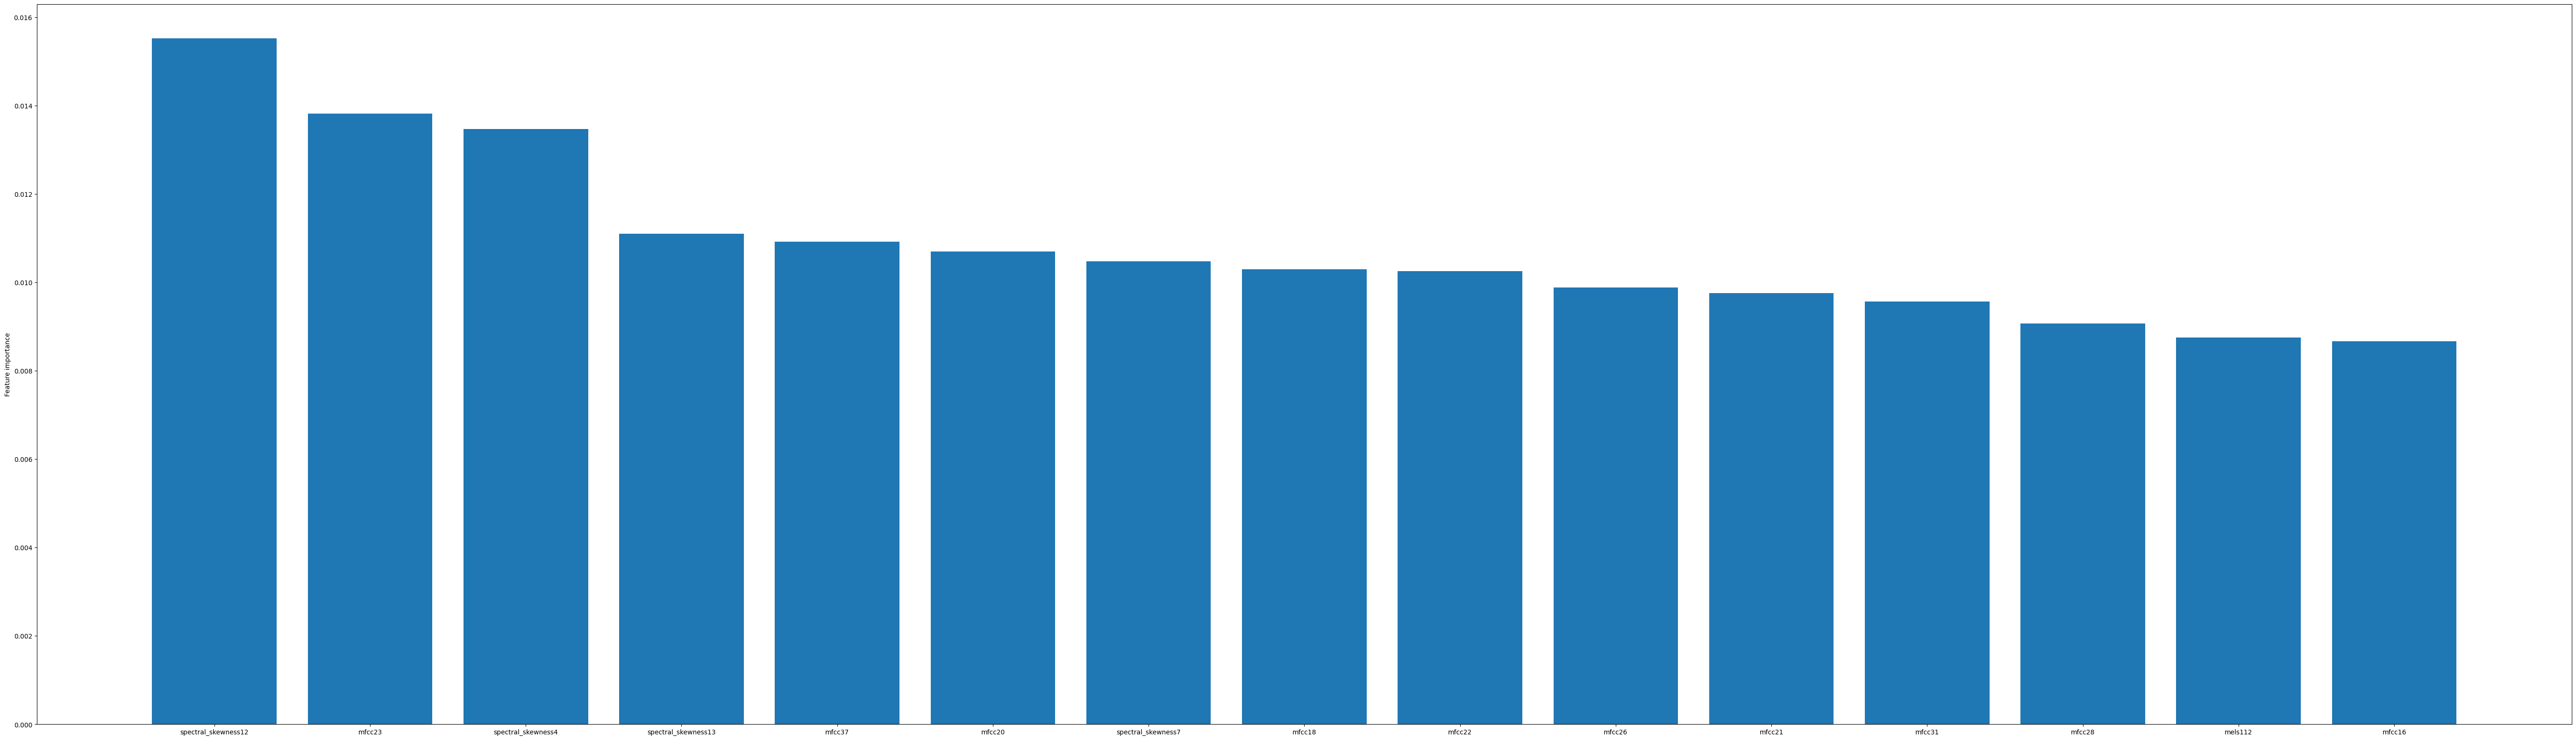

In [66]:
fig, ax = plt.subplots(figsize = (70,20))

feature = [features_importance[i][1] for i in range(15)]
counts = [features_importance[i][0] for i in range(15)]

ax.bar(feature, counts)
ax.set_ylabel('Feature importance')

plt.savefig("feature_random_forest.png")
plt.show()

In [67]:
pca = PCA(0.95)
X_pca = pca.fit_transform(X_scaled)

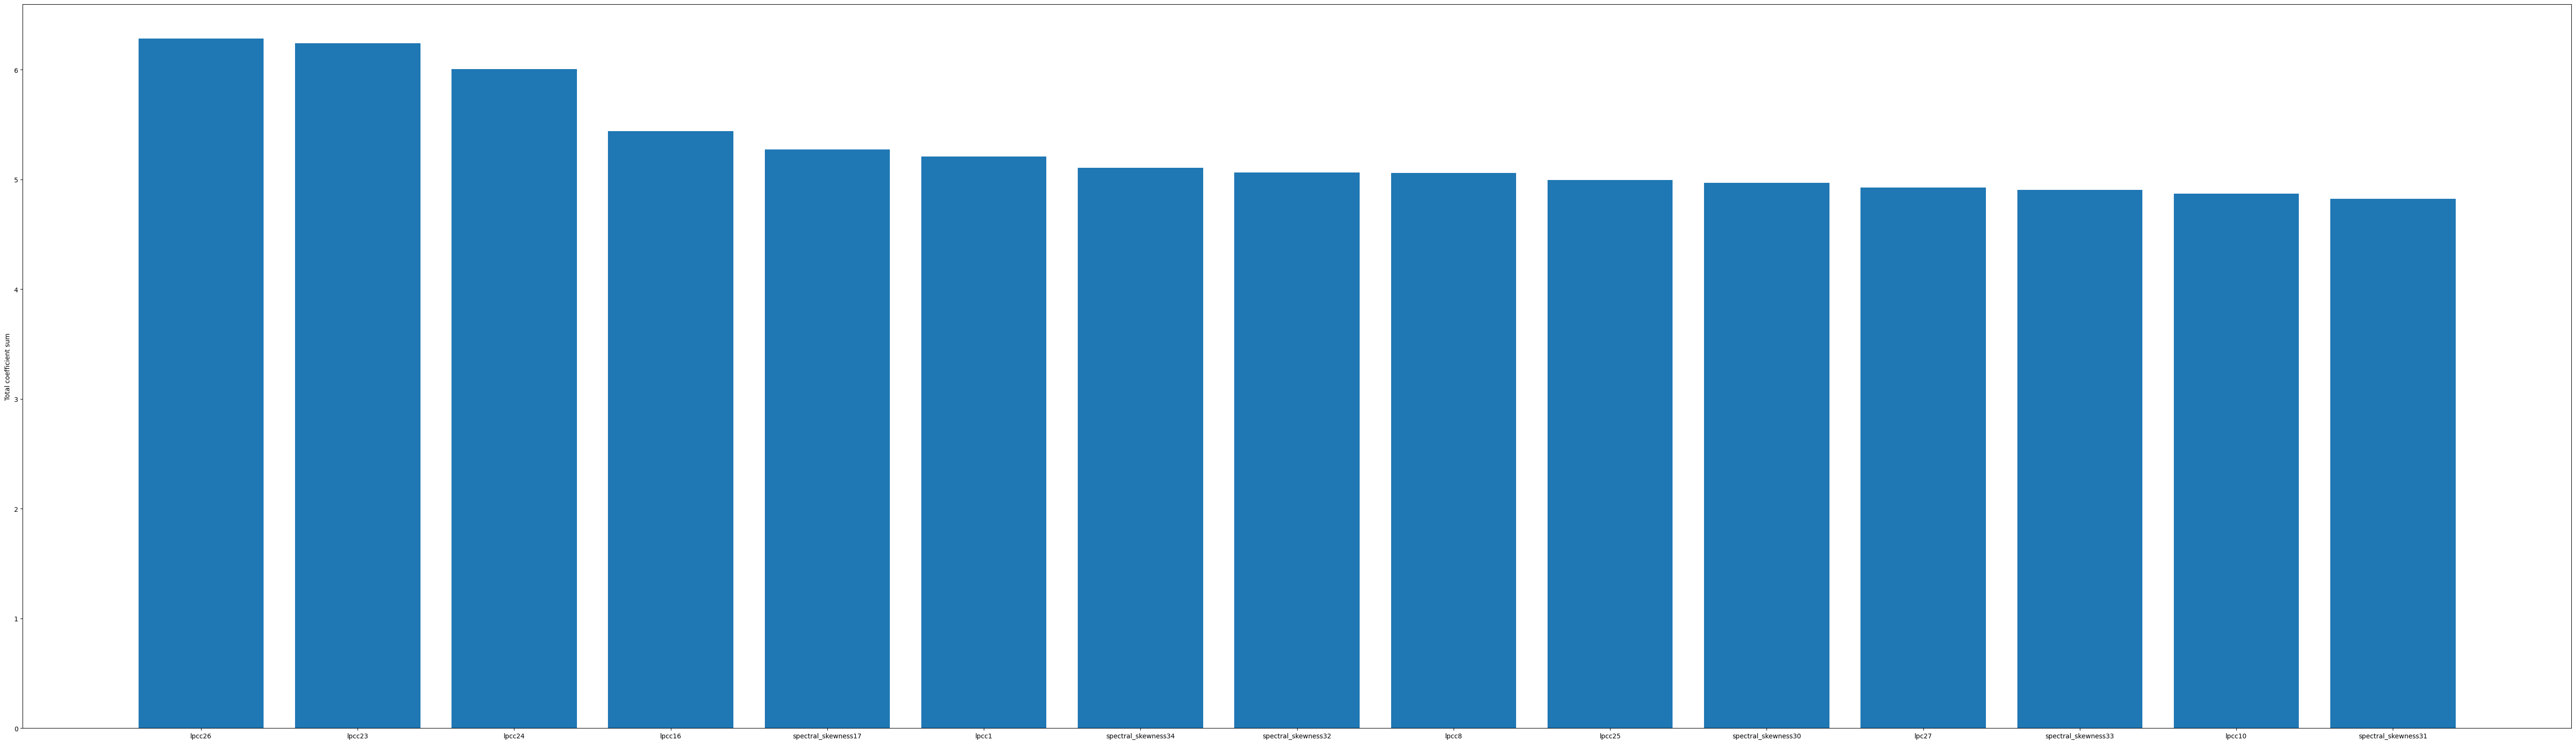

In [68]:
comps = pca.components_

num_comps, num_features = comps.shape
feature_dict = dict()

for name in names:
    feature_dict[name] = 0

for i in range(num_comps):
    for j in range(num_features):
        feature_dict[names[j]] += np.abs(comps[i][j])

features_importance = [(feature_dict[name], name) for name in names]

features_importance = sorted(features_importance ,reverse = True)

fig, ax = plt.subplots(figsize = (70,20))

feature = [features_importance[i][1] for i in range(15)]
counts = [features_importance[i][0] for i in range(15)]

ax.bar(feature, counts)
ax.set_ylabel('Total coefficient sum')

plt.savefig("feature_pca_dot.png")
plt.show()

In [33]:
df['label'].value_counts()

label
fear       400
angry      400
disgust    400
neutral    400
happy      400
sad        400
ps         400
Name: count, dtype: int64

In [226]:
labels = ['fear', 'angry', 'disgust', 'neutral', 'sad', 'ps', 'happy']

In [227]:
labels_color = {'fear':'red' ,'angry':'chocolate', 'disgust':'yellow', 'neutral':'forestgreen', 'sad': 'aqua', 'ps': 'steelblue', 'happy':'indigo'}
labels_ind = {'fear':0 ,'angry':1, 'disgust':2, 'neutral':3, 'sad': 4, 'ps': 5, 'happy':6}

In [ ]:
def get_waveplot(signal, sr):
    return signal

In [50]:
func_list = {'spec_centroid':get_spec_centroid, 'stft':get_stft, 'mels': get_mel, 'zero crossing rate': get_zero_crossings, 'MFCC':
            get_mfcc, 'spec_bandwidth':get_spec_bandwidth, 'RMS': get_RMS_mean, 'spec flux': get_spec_flux_mean, 'STE': get_STE_mean, 'temporal centroid'
            :temporal_centroid, 'lpc':get_lpc_mean, 'peak f': get_peak_f, 'spec roll off': get_spec_roll_off, 'spec skewness': spectral_skewness,
            'spec kurtosis': get_spectral_kurtosis, 'LPCC': get_LPCC, 'waveplot': get_waveplot}

In [51]:
def to_remove(sample_array, func_name):
    
    if(np.isnan(sample_array).any() or np.isinf(sample_array).any()): return True
    if(func_name == 'LPC'):
        s1 = sample_array < 1
        s2 = sample_array > -1
        if(np.all(s1) and np.all(s2)): return False
    
    return False

In [52]:
def get_analysis(func_name):
    
    func = func_list[func_name]
    vals = {}
    counts = {}
    for emotion in labels:
        vals[emotion] = None
        counts[emotion] = 0
    
    extend_names = ['stft', 'mels', 'MFCC', 'LPCC', 'spec_centroid', 'spec_bandwidth', 'peak f', 'spec roll off', 'zero crossing rate', 'waveplot']
    extend = func_name in extend_names

    for ind in tqdm(df.index):
   
        signal, sr = librosa.load(df['addr'][ind])
        if(extend): signal = np.pad(signal, (0, int((max_duration - librosa.get_duration(y = signal, sr = sr)) * sr)))
        emotion = df['label'][ind]
        val_to_add = func(signal, sr)
        if(to_remove(val_to_add, func_name)): continue
        if(vals[emotion] is None): vals[emotion] = val_to_add
        else: vals[emotion] += val_to_add
        counts[emotion]+=1
                
    for emotion in labels:
        if(vals[emotion] is not None): vals[emotion] = vals[emotion]/counts[emotion]
            
    return vals 

In [53]:
y_frequency = {'spec_centroid':0,  'spec_bandwidth':0, 'peak f':0, 'spec roll off':0}
y_rate = {'zero crossing rate': 0}
y_log_scale = {'mels':0, 'MFCC':0, 'LPCC': 0, 'stft':0}
y_absolute = {'lpc':0, 'spec flux':0, 'spec skewness': 0, 'spec kurtosis':0}
y_energy = {'STE':0}
y_RMS = {'RMS':0}
y_time = {'temporal_centroid':0}

In [54]:
import matplotlib

In [55]:
def show_analysis(feature):
   
    vals = get_analysis(feature)
    n = vals['fear'].shape[0]
    x = range(1,n+1)
    axis_labels = []
    for i in range(1,n+1):
        if(feature != 'spec skewness' and feature != 'spec kurtosis') : axis_labels.append(feature + "{}".format(i))
        else: axis_labels.append(i)
        
    if(feature == 'LPCC' or feature == 'stft'):
        
        fig, axes = plt.subplots(nrows = 4,ncols = 2, figsize = (25, 25))
        
        for emotion in vals.keys():
            val_to_plot = vals[emotion]
            if(feature == 'stft'): axes[int(labels_ind[emotion]/2) ,int(labels_ind[emotion]%2)].set_title('Spectrogram for {} emotion'.format(emotion))
            else: axes[int(labels_ind[emotion]/2) ,int(labels_ind[emotion]%2)].set_title('LPCCs for {} emotion'.format(emotion))
            img = librosa.display.specshow(val_to_plot, x_axis = 'time', y_axis = 'log', ax = axes[int(labels_ind[emotion]/2) ,int(labels_ind[emotion]%2)])
            plt.colorbar(img, ax = axes[int(labels_ind[emotion]/2) ,int(labels_ind[emotion]%2)], format='%+2.0f dB')
        
    elif(feature == 'MFCC' or feature == 'mels'):
        
        fig, axes = plt.subplots(nrows = 4,ncols = 2, figsize = (25, 25))
        
        for emotion in vals.keys():
            val_to_plot = vals[emotion]
            if(feature == 'MFCC'): 
                axes[int(labels_ind[emotion]/2) ,int(labels_ind[emotion]%2)].set_title('MFCCs for {} emotion'.format(emotion))
                val_to_plot = val_to_plot.T
            else: axes[int(labels_ind[emotion]/2), int(labels_ind[emotion]%2)].set_title('Mel Spectrogram for {} emotion'.format(emotion))
            img = librosa.display.specshow(val_to_plot, x_axis = 'time', y_axis = 'mel', ax = axes[int(labels_ind[emotion]/2) ,int(labels_ind[emotion]%2)])
            plt.colorbar(img, ax = axes[int(labels_ind[emotion]/2) ,int(labels_ind[emotion]%2)], format='%+2.0f dB')
            
    elif(feature == 'spec roll off' or feature == 'peak f' or feature == 'spec_centroid' or feature == 'spec_bandwidth'):
        
        plt.figure(figsize = (20,10))
        x = np.linspace(0, max_duration, vals['fear'].shape[0])
        
        for emotion in vals.keys():
            val_to_plot = vals[emotion]
            plt.plot(x, val_to_plot, color = labels_color[emotion], label = emotion)
        
        plt.legend(loc = "upper right")
        plt.title(feature)
        if(feature == 'zero crossing rate'): plt.ylabel('Rate')
        else: plt.ylabel('Frequency')
        plt.xlabel('Time')
        plt.savefig('temp.png')
        
    elif(feature == 'zero crossing rate'):
        
        fig, axes = plt.subplots(nrows = 7, ncols = 2, figsize = (50, 50))
        supporting_vals = get_analysis('waveplot')
        x = np.linspace(0, max_duration, vals['fear'].shape[0])
        
        for emotion in vals.keys():
            val_to_plot = vals[emotion]
            val_to_support = supporting_vals[emotion]
            
            axes[labels_ind[emotion] , 0].set_title('Waveplot for {} emotion'.format(emotion))
            axes[labels_ind[emotion] , 1].set_title('ZCR plot for {} emotion'.format(emotion))
            librosa.display.waveplot(y = val_to_support, x_axis = 'time', ax = axes[labels_ind[emotion], 0])
            plt.plot(x , val_to_plot, ax = axes[labels_ind[emotion] , 1])
            
    else:
        
        plt.figure(figsize = (20,10))
        for emotion in vals.keys():
            val_to_plot = vals[emotion]
            plt.scatter(x = axis_labels, y=val_to_plot, color=labels_color[emotion], label=emotion)

        if(feature in y_frequency): Value = "Frequency"
        elif(feature in y_rate): Value = "Rate"
        elif(feature in y_log_scale): Value = "Log Scale"
        elif(feature in y_absolute): Value = "Magnitude"
        elif(feature in y_energy): Value = "Energy"
        elif(feature in y_RMS): Value = "Root Mean Square"
        else: Value = "Time fraction"
    
        if(feature != 'spec skewness' and feature != 'spec kurtosis') : plt.legend(loc = "upper right")
        else: plt.legend(loc = "upper left")
        plt.title(feature)
        plt.ylabel(Value) 
        
    plt.savefig("temp.png")
    

100%|██████████| 2800/2800 [00:32<00:00, 86.92it/s] 


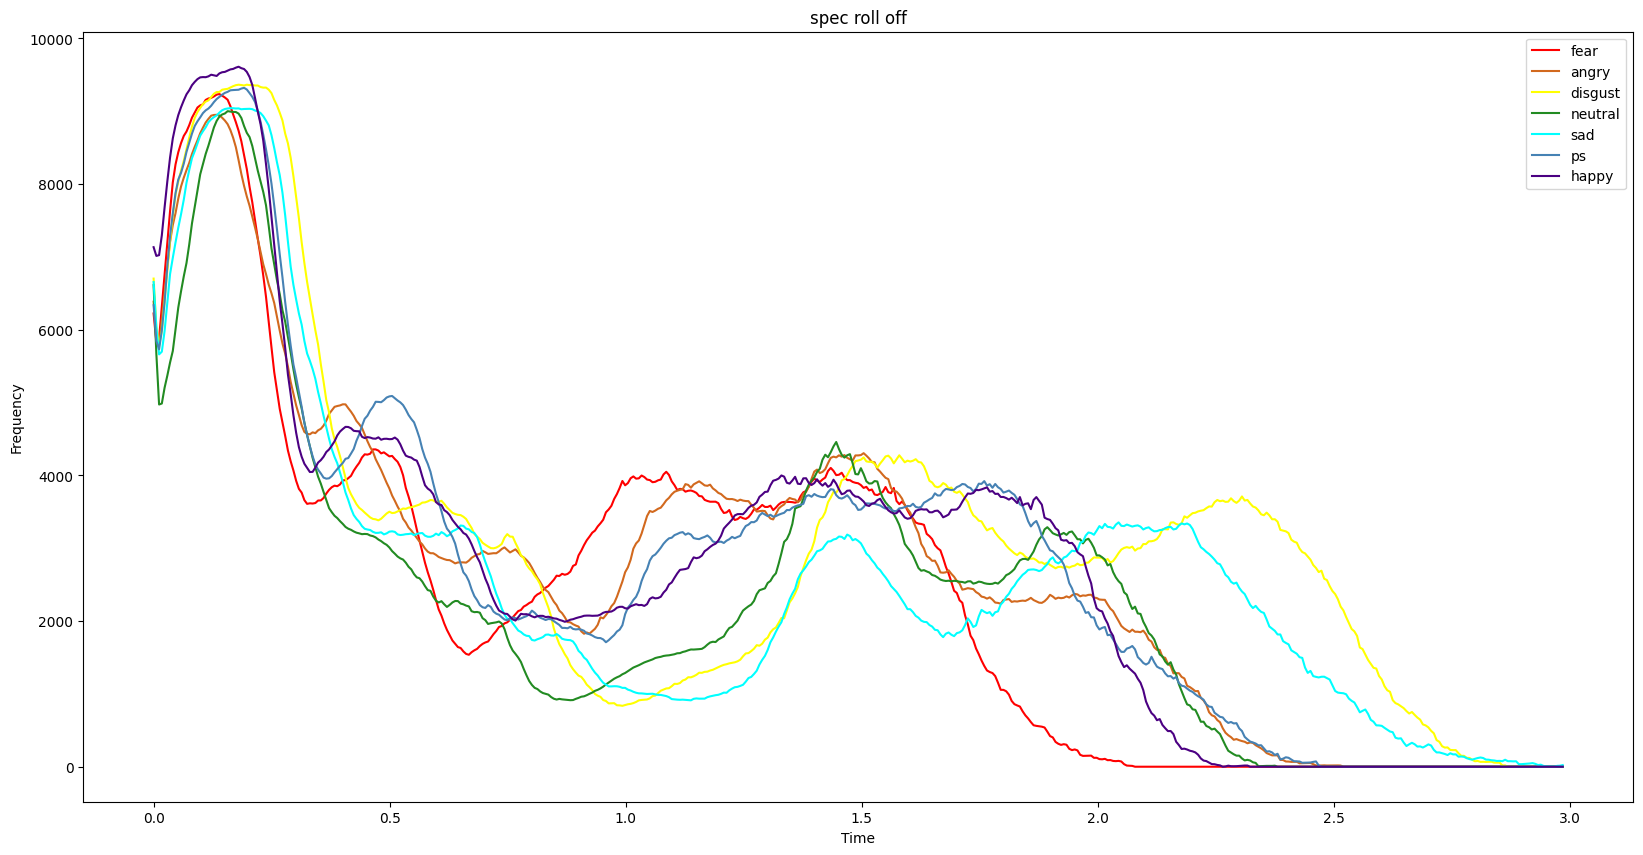

In [60]:
show_analysis('spec roll off')

In [16]:
get_STE(signal, sr).shape

(360, 1)

In [13]:
# Energy related stats
def STE_stats(signal, sr, perc1, perc2): 
    
    STE = get_STE(signal, sr)
    mean_STE = np.mean(STE)
    var_STE = np.var(STE)
    perc_50 = np.percentile(a = STE, q = perc1)
    perc_75 = np.percentile(a = STE, q = perc2)
    dur = librosa.get_duration(y = signal, sr = sr)    
    t = np.linspace(0, dur, num = STE.shape[0])   
    colors_ = []
    labels_ = []
    
    for i in range(STE.shape[0]): 
        
        if(STE[i] >= perc_75): 
            colors_.append('darkred')
            labels_.append('Greater than 75th percentile')
            
        elif(STE[i] >= perc_50): 
            colors_.append('red')
            labels_.append('Greater than mean')
            
        else: 
            colors_.append('green')
            labels_.append('Less than mean')
    
    plt.figure(figsize = (20, 10))
    plt.scatter(t, STE, c = colors_, alpha = 0.6)
    plt.legend(labels_, loc = 'best')
    plt.xlabel('time(s)')
    plt.title('Short time energies for each frame')
    plt.ylabel('Energy of the signal(m^2)')
    plt.show()
    

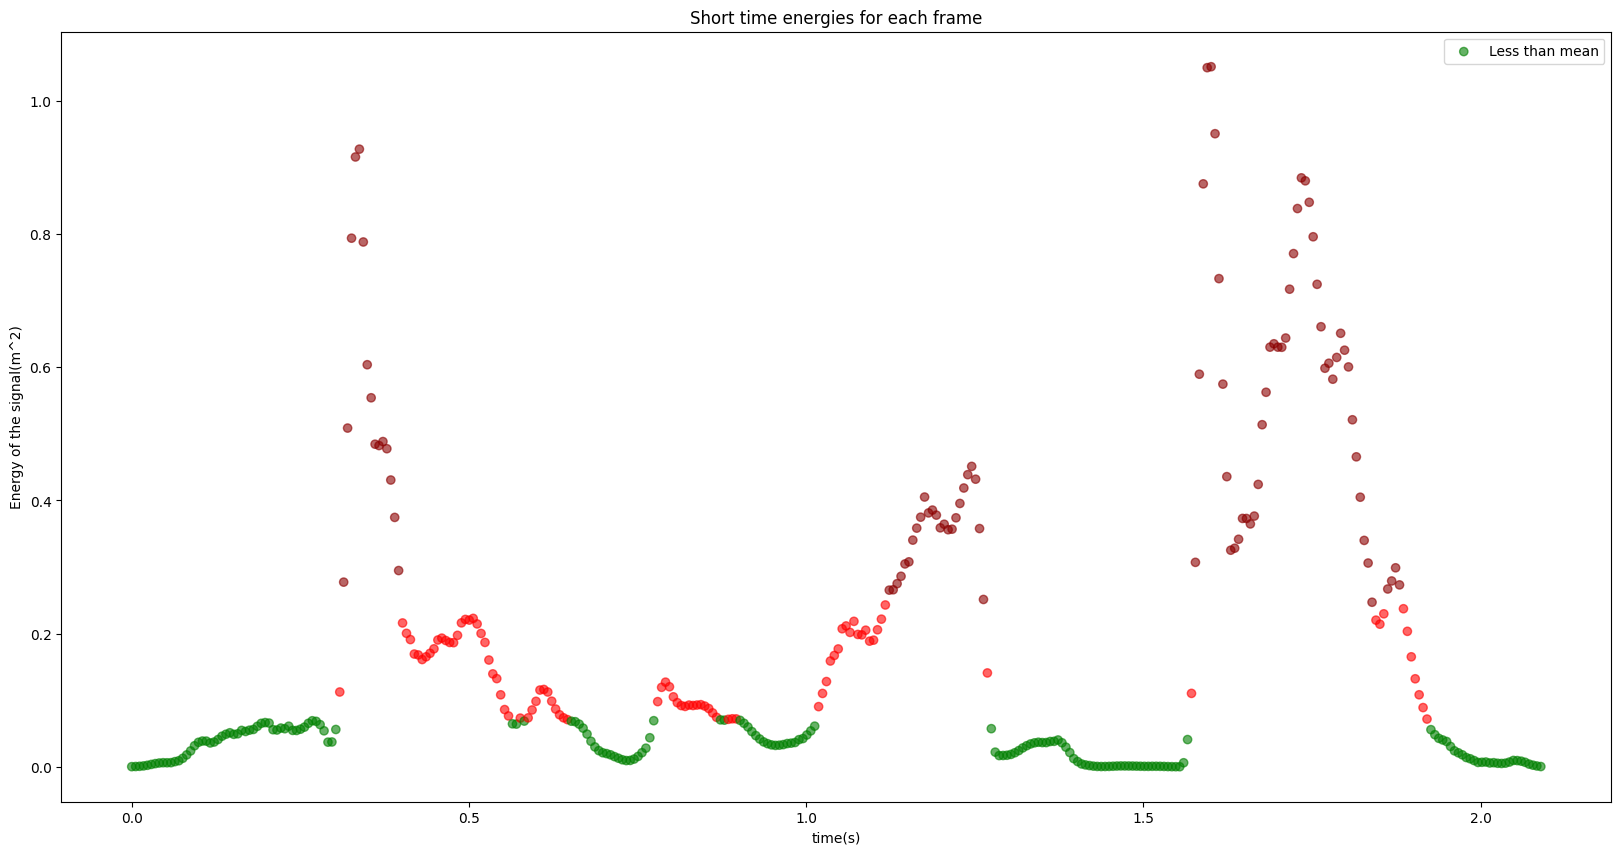

CPU times: user 2.03 s, sys: 178 ms, total: 2.2 s
Wall time: 2 s


In [14]:
%%time
STE_stats(signal, sr, 50, 75)

In [15]:
# ZCR related stats
def ZCR_stats(signal, sr, perc1, perc2): 
    
    ZCR = get_zero_crossings(signal, sr)
    mean_ZCR = np.mean(ZCR)
    var_ZCR = np.var(ZCR)
    perc_50 = np.percentile(a = ZCR, q = perc1)
    perc_75 = np.percentile(a = ZCR, q = perc2)
    dur = librosa.get_duration(y = signal, sr = sr)    
    t = np.linspace(0, dur, num = ZCR.shape[0])   
    colors_ = []
    labels_ = []
    
    for i in range(ZCR.shape[0]): 
        
        if(ZCR[i] >= perc_75): 
            colors_.append('darkred')
            labels_.append('Greater than 75th percentile')
            
        elif(ZCR[i] >= perc_50): 
            colors_.append('red')
            labels_.append('Greater than mean')
            
        else: 
            colors_.append('green')
            labels_.append('Less than mean')
            
    fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (20, 12))
    axes[1].plot(t, ZCR, alpha = 1)
    librosa.display.waveshow(y = signal, sr = sr, ax = axes[0])
    axes[1].set_title('Zero crossing rates for each frame')
    axes[0].set_title('Waveplot for the audio sample')
    axes[1].set_xlabel('Time(s)')
    axes[1].set_ylabel('Rate')
    axes[0].set_xlabel('Amplitude(m)')
#     plt.legend(labels_, loc = 'best')
    

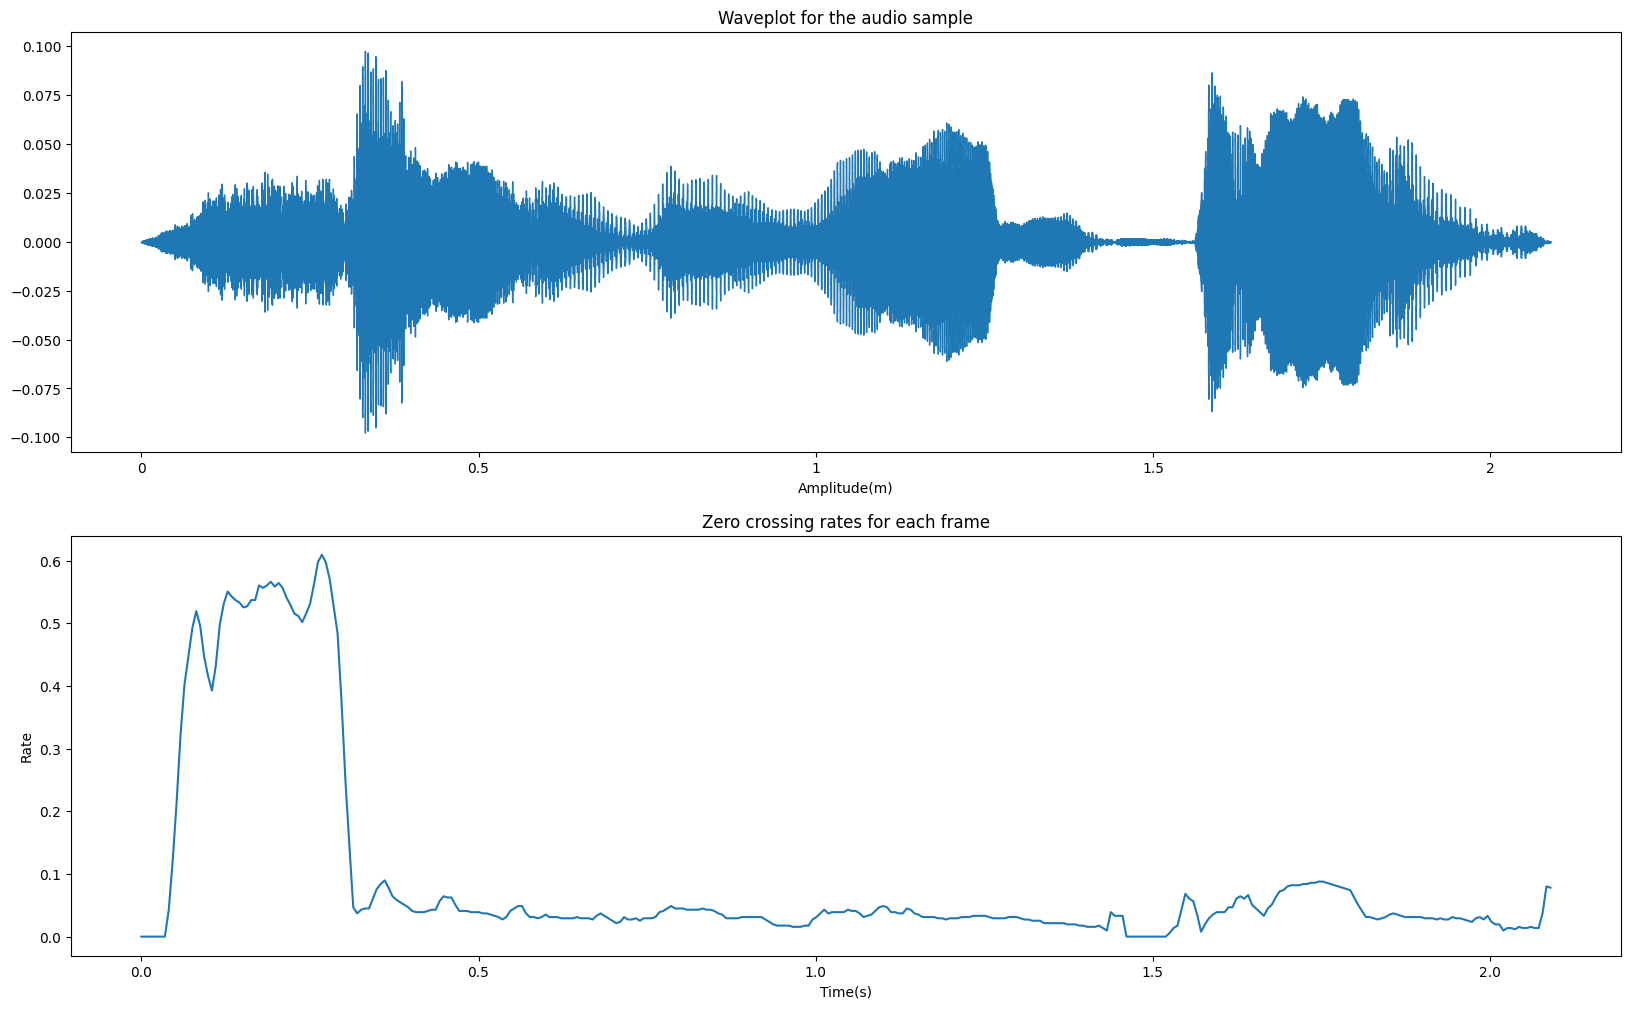

In [16]:
ZCR_stats(signal, sr, 50, 75)

In [17]:
# Spectral roll off
def spec_roll_off_stats(signal, sr, perc1, perc2): 
    
    spec_roll_off = get_spec_roll_off(signal, sr)
    mean_spec_roll_off = np.mean(spec_roll_off)
    var_spec_roll_off = np.var(spec_roll_off)
    perc_50 = np.percentile(a = spec_roll_off, q = perc1)
    perc_75 = np.percentile(a = spec_roll_off, q = perc2)
    dur = librosa.get_duration(y = signal, sr = sr)    
    t = np.linspace(0, dur, num = spec_roll_off.shape[0])   
    colors_ = []
    labels_ = []
    
    for i in range(spec_roll_off.shape[0]): 
        
        if(spec_roll_off[i] >= perc_75): 
            colors_.append('darkred')
            labels_.append('Greater than 75th percentile')
            
        elif(spec_roll_off[i] >= perc_50): 
            colors_.append('red')
            labels_.append('Greater than mean')
            
        else: 
            colors_.append('green')
            labels_.append('Less than mean')
    
    plt.figure(figsize = (20, 10))
    plt.scatter(t, spec_roll_off, c = colors_, alpha = 0.6)
    plt.legend(labels_, loc = 'best')
    plt.xlabel('time(s)')
    plt.title('Spectral roll off values for each frame')
    plt.ylabel('Frequency(Hz)')
    plt.show()

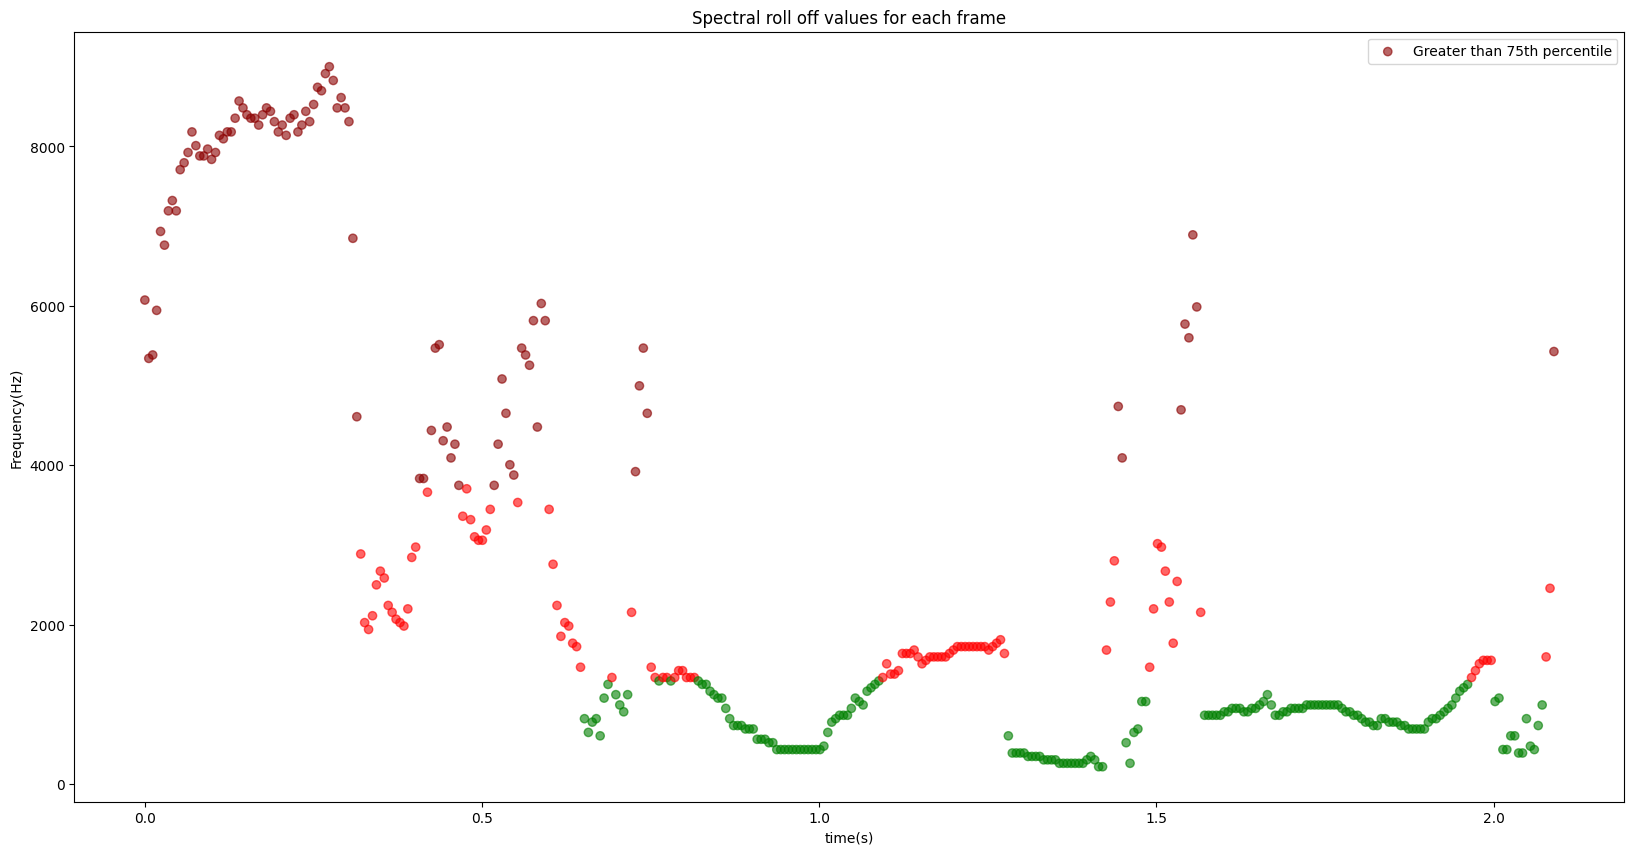

In [18]:
spec_roll_off_stats(signal, sr, 50, 75)

In [19]:
get_spec_centroid(signal, sr).shape

(360, 1)

In [20]:
# Spectral centroid
def spec_centroid_stats(signal, sr, perc1, perc2): 
    
    spec_centroid = get_spec_centroid(signal, sr)
    mean_spec_centroid = np.mean(spec_centroid)
    var_spec_centroid = np.var(spec_centroid)
    perc_50 = np.percentile(a = spec_centroid, q = perc1)
    perc_75 = np.percentile(a = spec_centroid, q = perc2)
    dur = librosa.get_duration(y = signal, sr = sr)    
    t = np.linspace(0, dur, num = spec_centroid.shape[0])   
    colors_ = []
    labels_ = []
    
    for i in range(spec_centroid.shape[0]): 
        
        if(spec_centroid[i] >= perc_75): 
            colors_.append('darkred')
            labels_.append('Greater than 75th percentile')
            
        elif(spec_centroid[i] >= perc_50): 
            colors_.append('red')
            labels_.append('Greater than mean')
            
        else: 
            colors_.append('green')
            labels_.append('Less than mean')
    
    plt.figure(figsize = (20, 10))
    plt.scatter(t, spec_centroid, c = colors_, alpha = 0.6)
    plt.legend(labels_, loc = 'best')
    plt.xlabel('time(s)')
    plt.title('Spectral centroid values for each frame')
    plt.ylabel('Frequency(Hz)')
    plt.show()


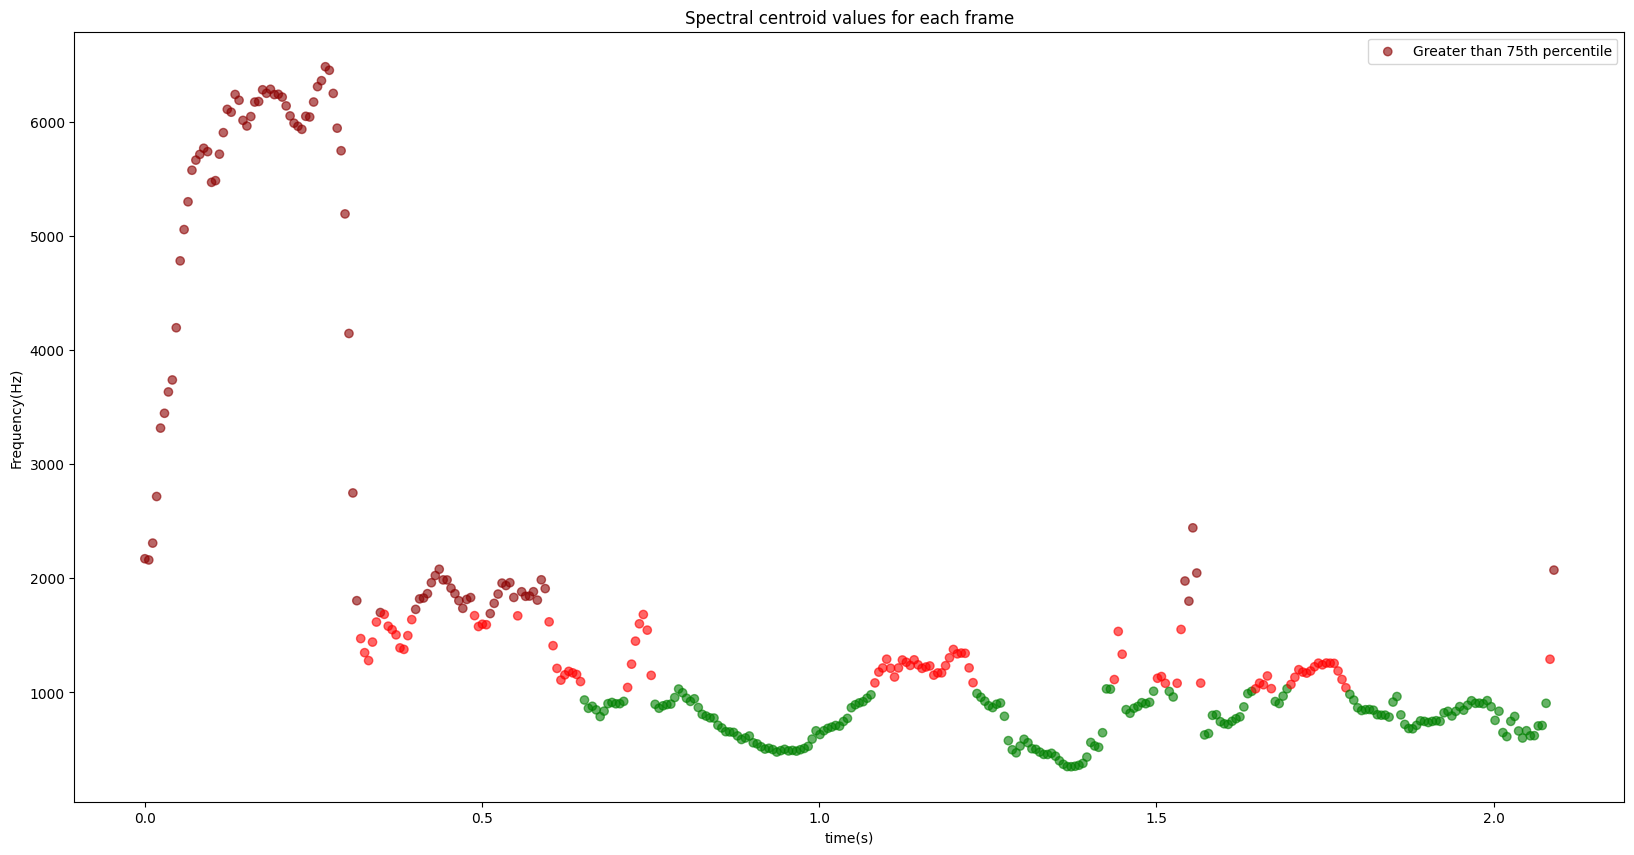

In [21]:
spec_centroid_stats(signal, sr, 50, 75)

In [60]:
emotions = ['fear', 'angry', 'disgust', 'neutral', 'sad', 'ps', 'happy']
labels_color = {'fear':'red' ,'angry':'chocolate', 'disgust':'yellow', 'neutral':'forestgreen', 'sad': 'aqua', 'ps': 'steelblue', 'happy':'indigo'}
labels_ind = {'fear':0 ,'angry':1, 'disgust':2, 'neutral':3, 'sad': 4, 'ps': 5, 'happy':6}

In [23]:
# Global spectral centroid values
def global_spectral_centroid(df):
    
    features_map = dict()
    for emotion in emotions:
        features_map[emotion] = []
    
    for ind in tqdm(df.index):
        signal, sr = librosa.load(df['addr'][ind])
        emotion = df['label'][ind]
        features_map[emotion].append(get_spec_centroid_mean(signal, sr))
        
    plt.figure(figsize = (20,10))
    for emotion in emotions:
        val_to_plot = features_map[emotion]
        x = [labels_ind[emotion]] * len(val_to_plot)
        plt.scatter(x, val_to_plot, color = labels_color[emotion], label = emotion, alpha = 0.6)

    plt.legend(loc = "best")
    plt.title("Global data trends in spectral centroid values")
    plt.ylabel('Frequency(Hz)')

100%|██████████| 2800/2800 [00:22<00:00, 124.36it/s]


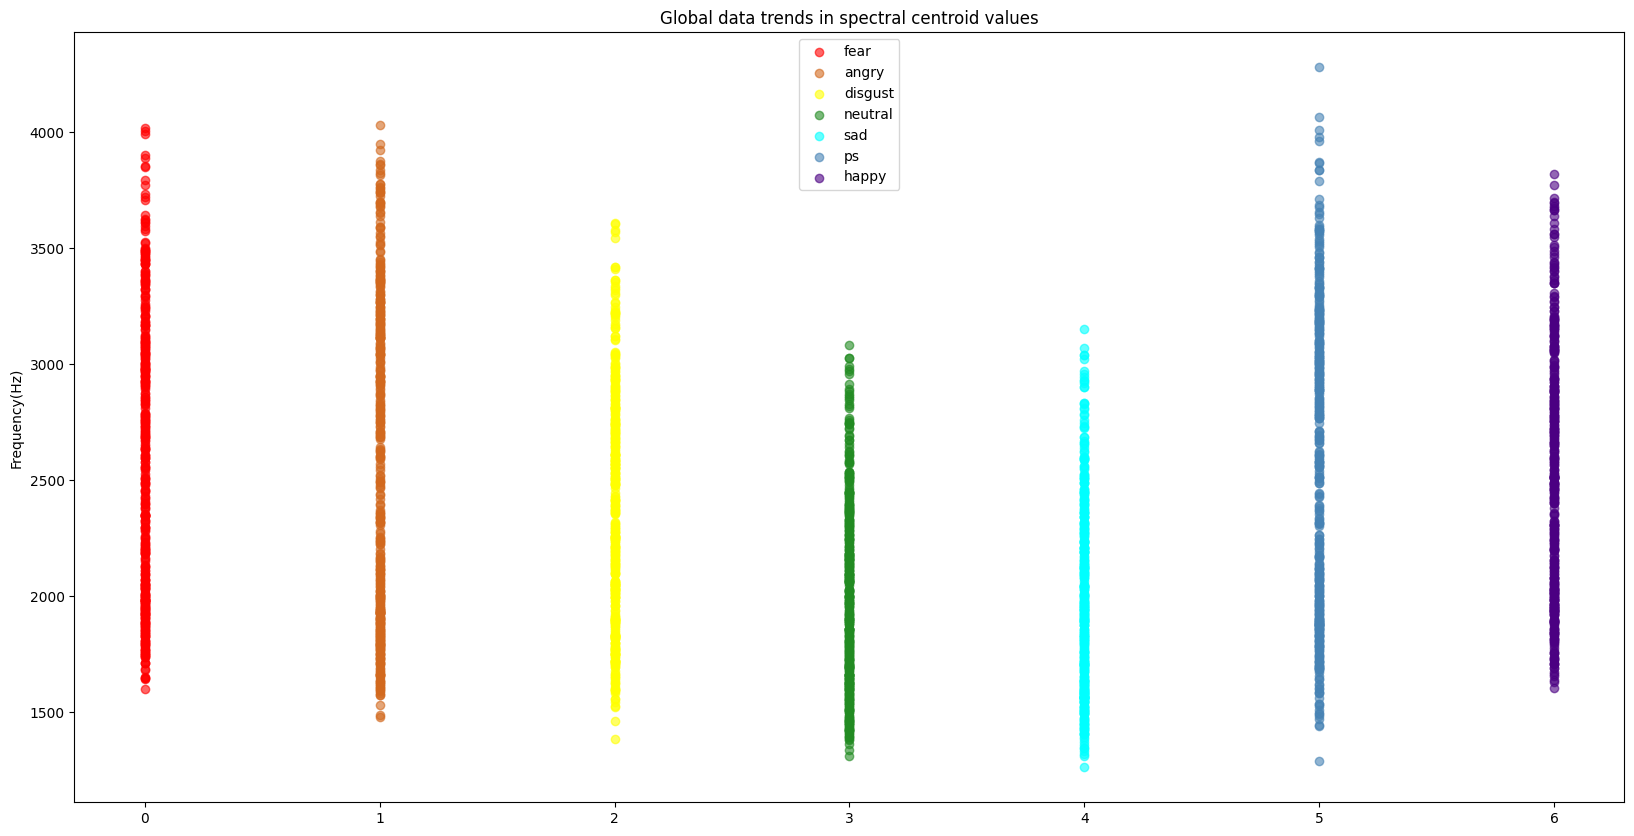

In [24]:
global_spectral_centroid(df)

In [25]:
# Global spectral roll off trends
def global_spectral_roll_off(df):
    
    features_map = dict()
    for emotion in emotions:
        features_map[emotion] = []
    
    for ind in tqdm(df.index):
        signal, sr = librosa.load(df['addr'][ind])
        emotion = df['label'][ind]
        features_map[emotion].append(get_spec_roll_off_mean(signal, sr))
        
    plt.figure(figsize = (20,10))
    for emotion in emotions:
        val_to_plot = features_map[emotion]
        x = [labels_ind[emotion]] * len(val_to_plot)
        plt.scatter(x, val_to_plot, color = labels_color[emotion], label = emotion, alpha = 0.6)

    plt.legend(loc = "best")
    plt.title("Global data trends in spectral roll values")
    plt.ylabel('Frequency(Hz)')

100%|██████████| 2800/2800 [00:25<00:00, 111.31it/s]


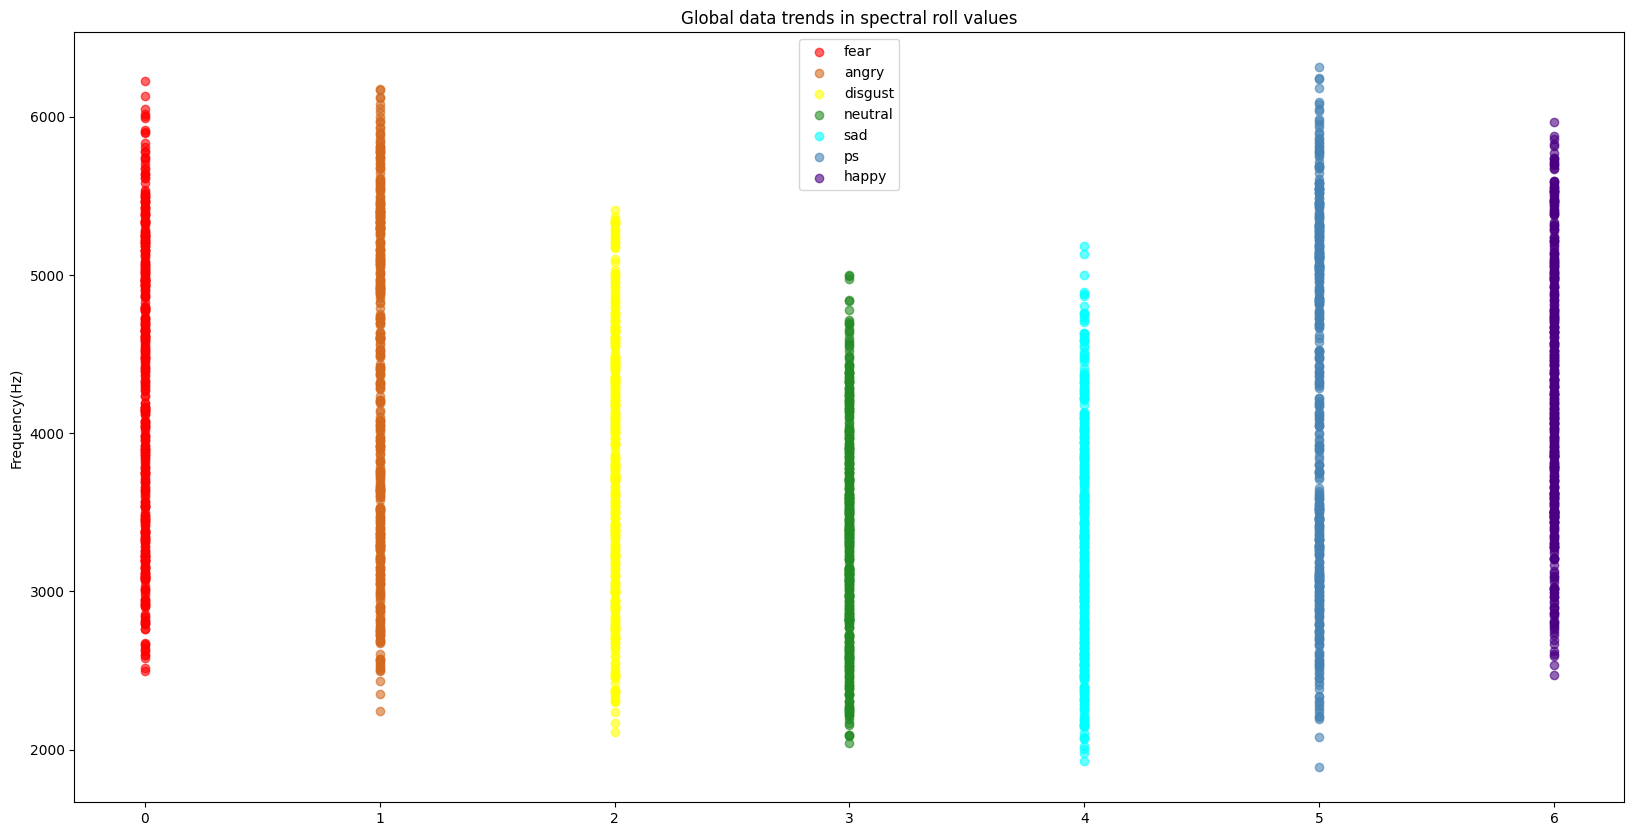

In [27]:
global_spectral_roll_off(df)

In [26]:
# Spectrogram
def stft_stats(signal, sr):
    
    fig, axes = plt.subplots(nrows = 2, figsize = (20, 20))
    spects = np.abs(librosa.stft(y = signal, n_fft = 512, hop_length = 128))
    energy_sums = np.sum(a = spects**2, axis = 1)
    librosa.display.specshow(librosa.power_to_db(np.abs(spects)), x_axis = 'time', y_axis = 'hz', ax = axes[0])
    energy_sums = energy_sums / np.sum(a = energy_sums, axis = 0)
    frequency_energies = []
    for i in range(energy_sums.shape[0]):
        frequency_energies.append((energy_sums[i], ((i+1) *sr / 257)))
        
    x_labels = []
    y_labels = []
    
    for i in range(len(frequency_energies)):
        y_labels.append(frequency_energies[i][0])
        x_labels.append(frequency_energies[i][1])
        
    axes[1].scatter(x_labels, y_labels, alpha = 0.6)
    axes[1].set_xlabel('Frequency')
    axes[1].set_ylabel('Proportion of the total energy')
    frequency_energies.sort(reverse = True)

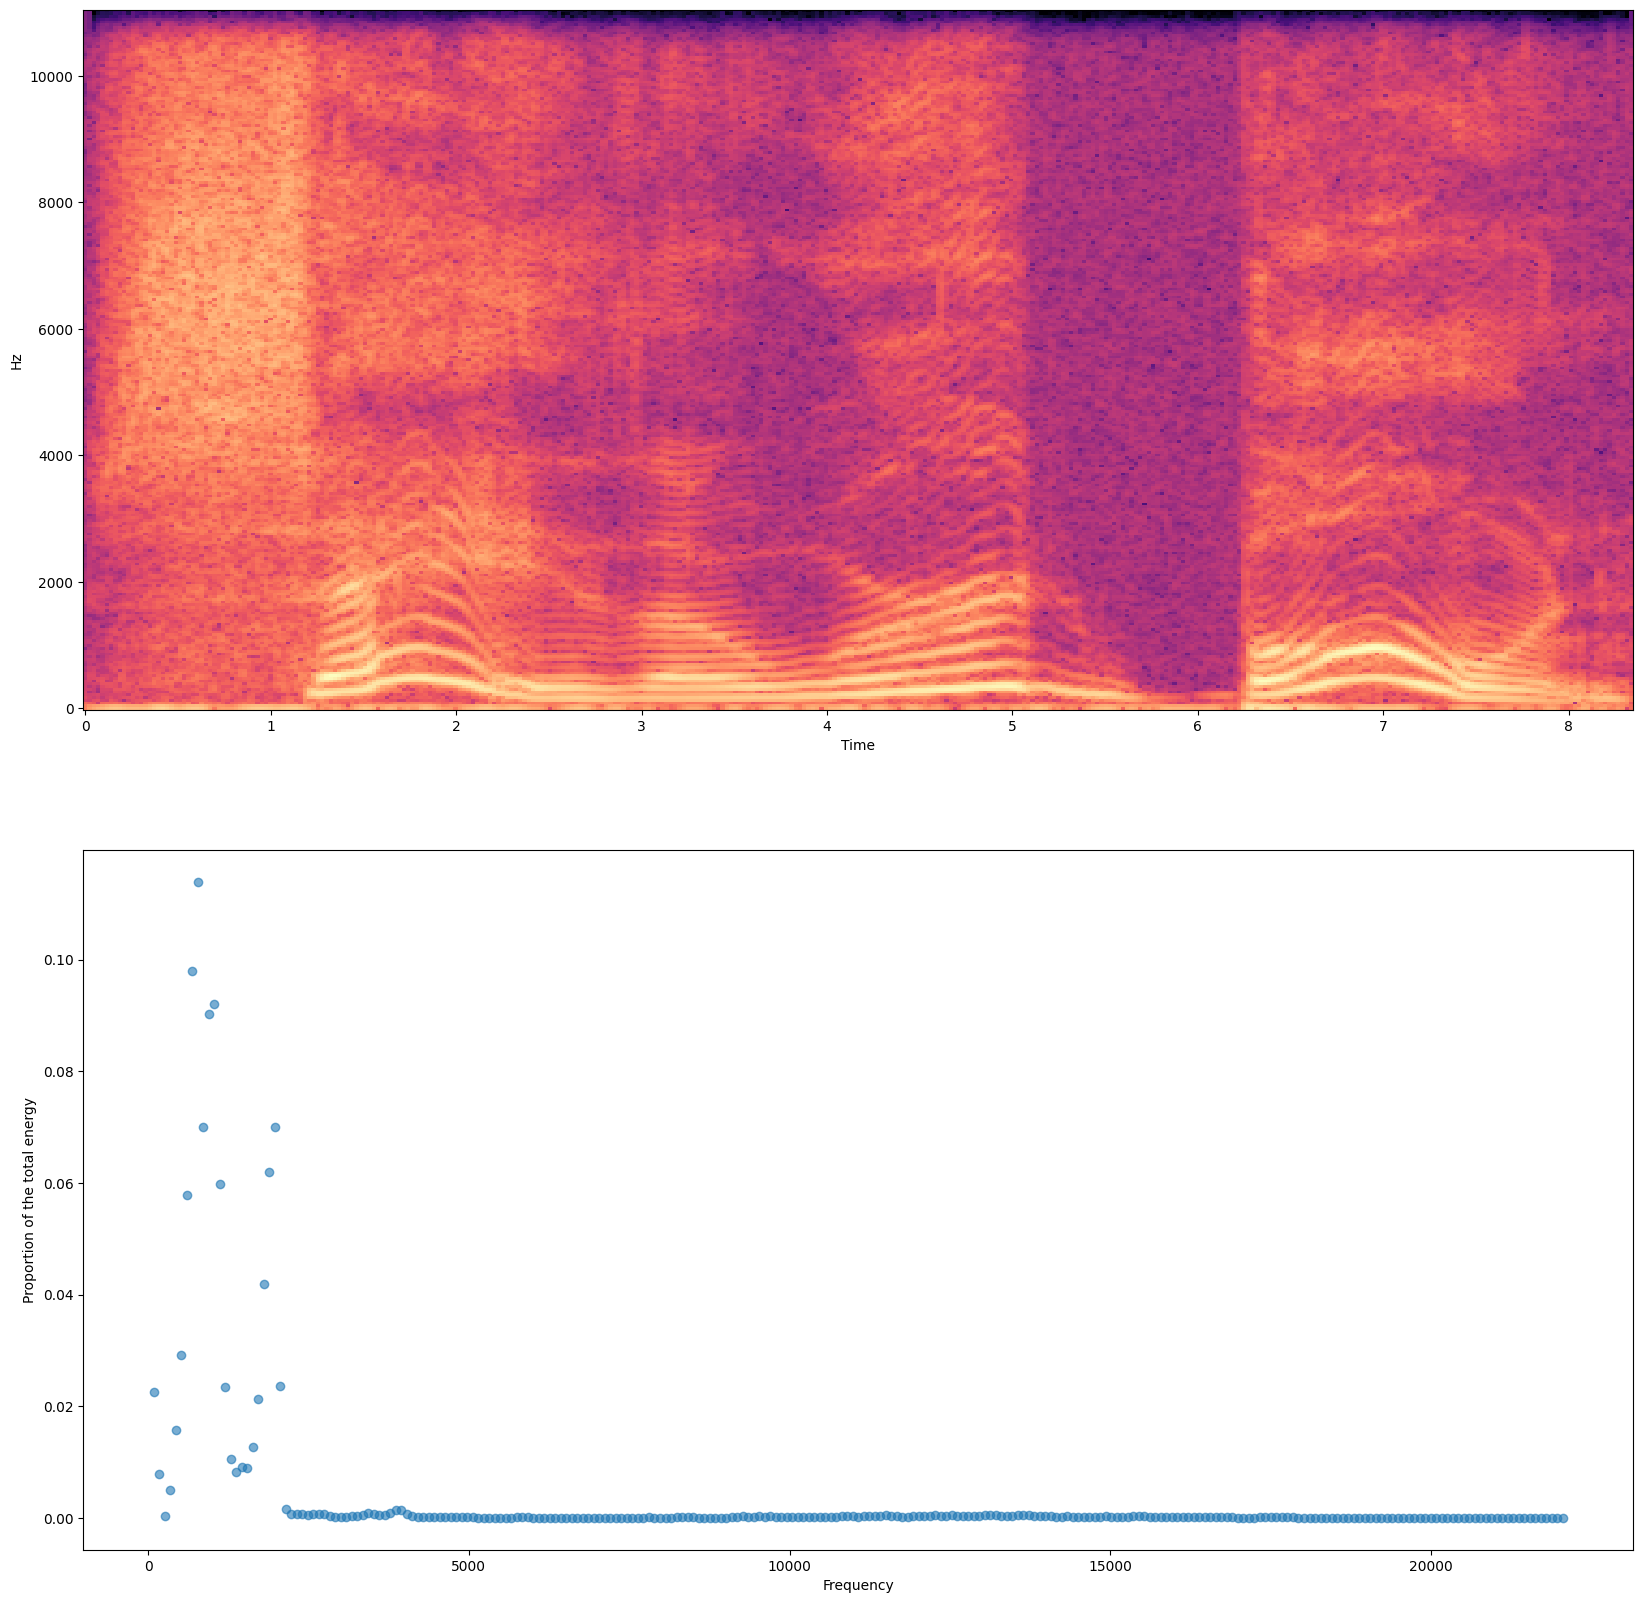

In [27]:
stft_stats(signal, sr)

In [28]:
# MFCC
def mfcc_stats(signal, sr):
    
    fig, axes = plt.subplots(nrows = 2, figsize = (20, 20))
    mfccs = librosa.feature.mfcc(y = signal, sr = sr, n_mfcc = 20, n_fft = 512, hop_length = 128)
    energy_sums = np.sum(a = mfccs**2, axis = 1)
    librosa.display.specshow(mfccs, x_axis = 'time', y_axis = 'mel', ax = axes[0])
    energy_sums = energy_sums / np.sum(a = energy_sums, axis = 0)
    coefficient_energies = []
    for i in range(energy_sums.shape[0]):
        coefficient_energies.append((energy_sums[i], 'mfcc{}'.format(i)))
        
    x_labels = []
    y_labels = []
    
    for i in range(len(coefficient_energies)):
        y_labels.append(coefficient_energies[i][0])
        x_labels.append(coefficient_energies[i][1])
        
    axes[1].scatter(x_labels, y_labels, alpha = 0.6)
    coefficient_energies.sort(reverse = True)

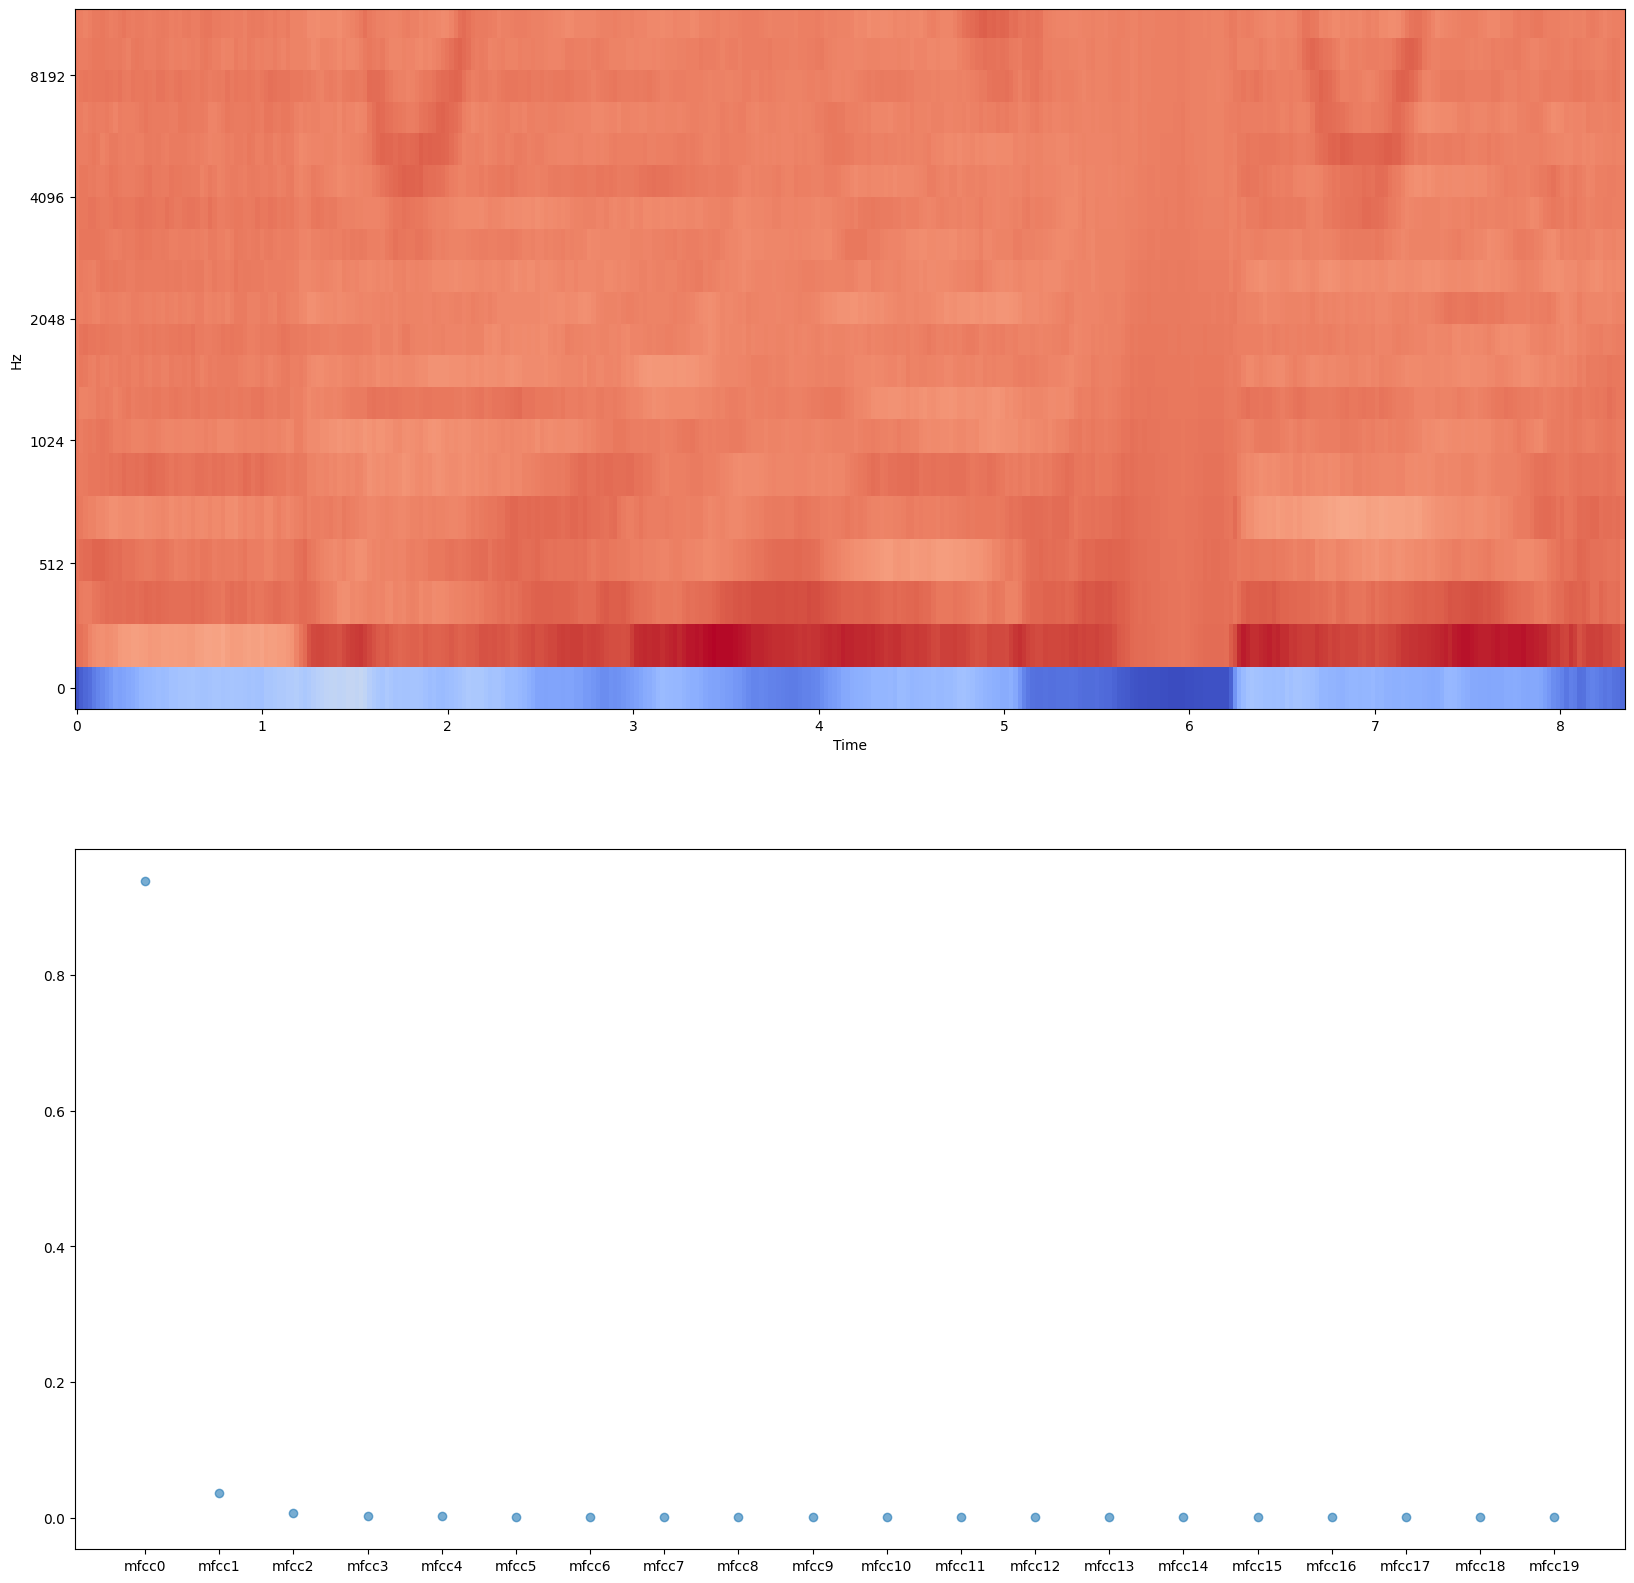

In [29]:
mfcc_stats(signal, sr)

In [ ]:
# Global mfcc trends



In [ ]:
# Global stft trends

In [35]:
# HOG
get_HOG(signal, sr)

array([0.02468882, 0.02685318, 0.02138334, 0.02138334, 0.02138334,
       0.02138334, 0.02138334, 0.02138334, 0.02138334, 0.02735061,
       0.02685336, 0.10235073, 0.10163293, 0.10300373, 0.10139041,
       0.1027473 , 0.08013649, 0.10195785, 0.10283261, 0.03464052,
       0.02138334, 0.10267293, 0.10304598, 0.10256948, 0.10183753,
       0.10105625, 0.08188572, 0.10225532, 0.10339673, 0.03720807,
       0.02138334, 0.10335027, 0.10223962, 0.10356875, 0.10356577,
       0.10206762, 0.07858462, 0.10180283, 0.10419601, 0.03099355,
       0.02138334, 0.10359108, 0.10233659, 0.1034412 , 0.1006884 ,
       0.10125066, 0.082128  , 0.10104524, 0.10317104, 0.05014073,
       0.02138334, 0.10215106, 0.10271163, 0.10325983, 0.09824973,
       0.09899743, 0.08268465, 0.10194923, 0.10282724, 0.03884857,
       0.02138334, 0.10253535, 0.10300997, 0.10350004, 0.10094478,
       0.09880134, 0.0856849 , 0.10297896, 0.10101681, 0.05240063,
       0.02138334, 0.10325805, 0.10167794, 0.103318  , 0.10234

In [ ]:
# LBP


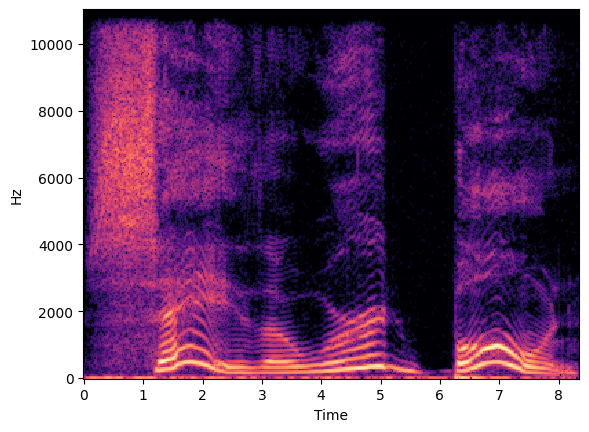

In [32]:
spects = librosa.amplitude_to_db(np.abs(librosa.stft(y = signal, n_fft = 512, hop_length = 128)))
librosa.display.specshow(spects, x_axis = 'time', y_axis = 'hz')

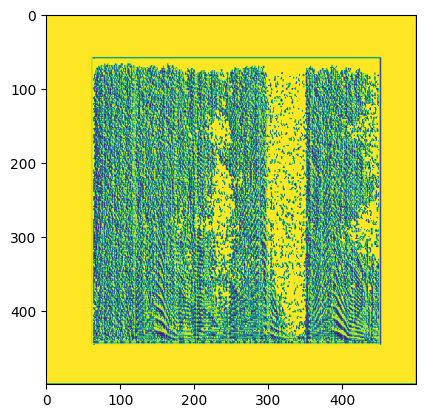

In [30]:
plt.imshow(get_LBP(signal, sr))

[9.07029478e-05 1.11111111e-02 1.12018141e-02 1.17913832e-02
 1.19727891e-02 1.60544218e-02]


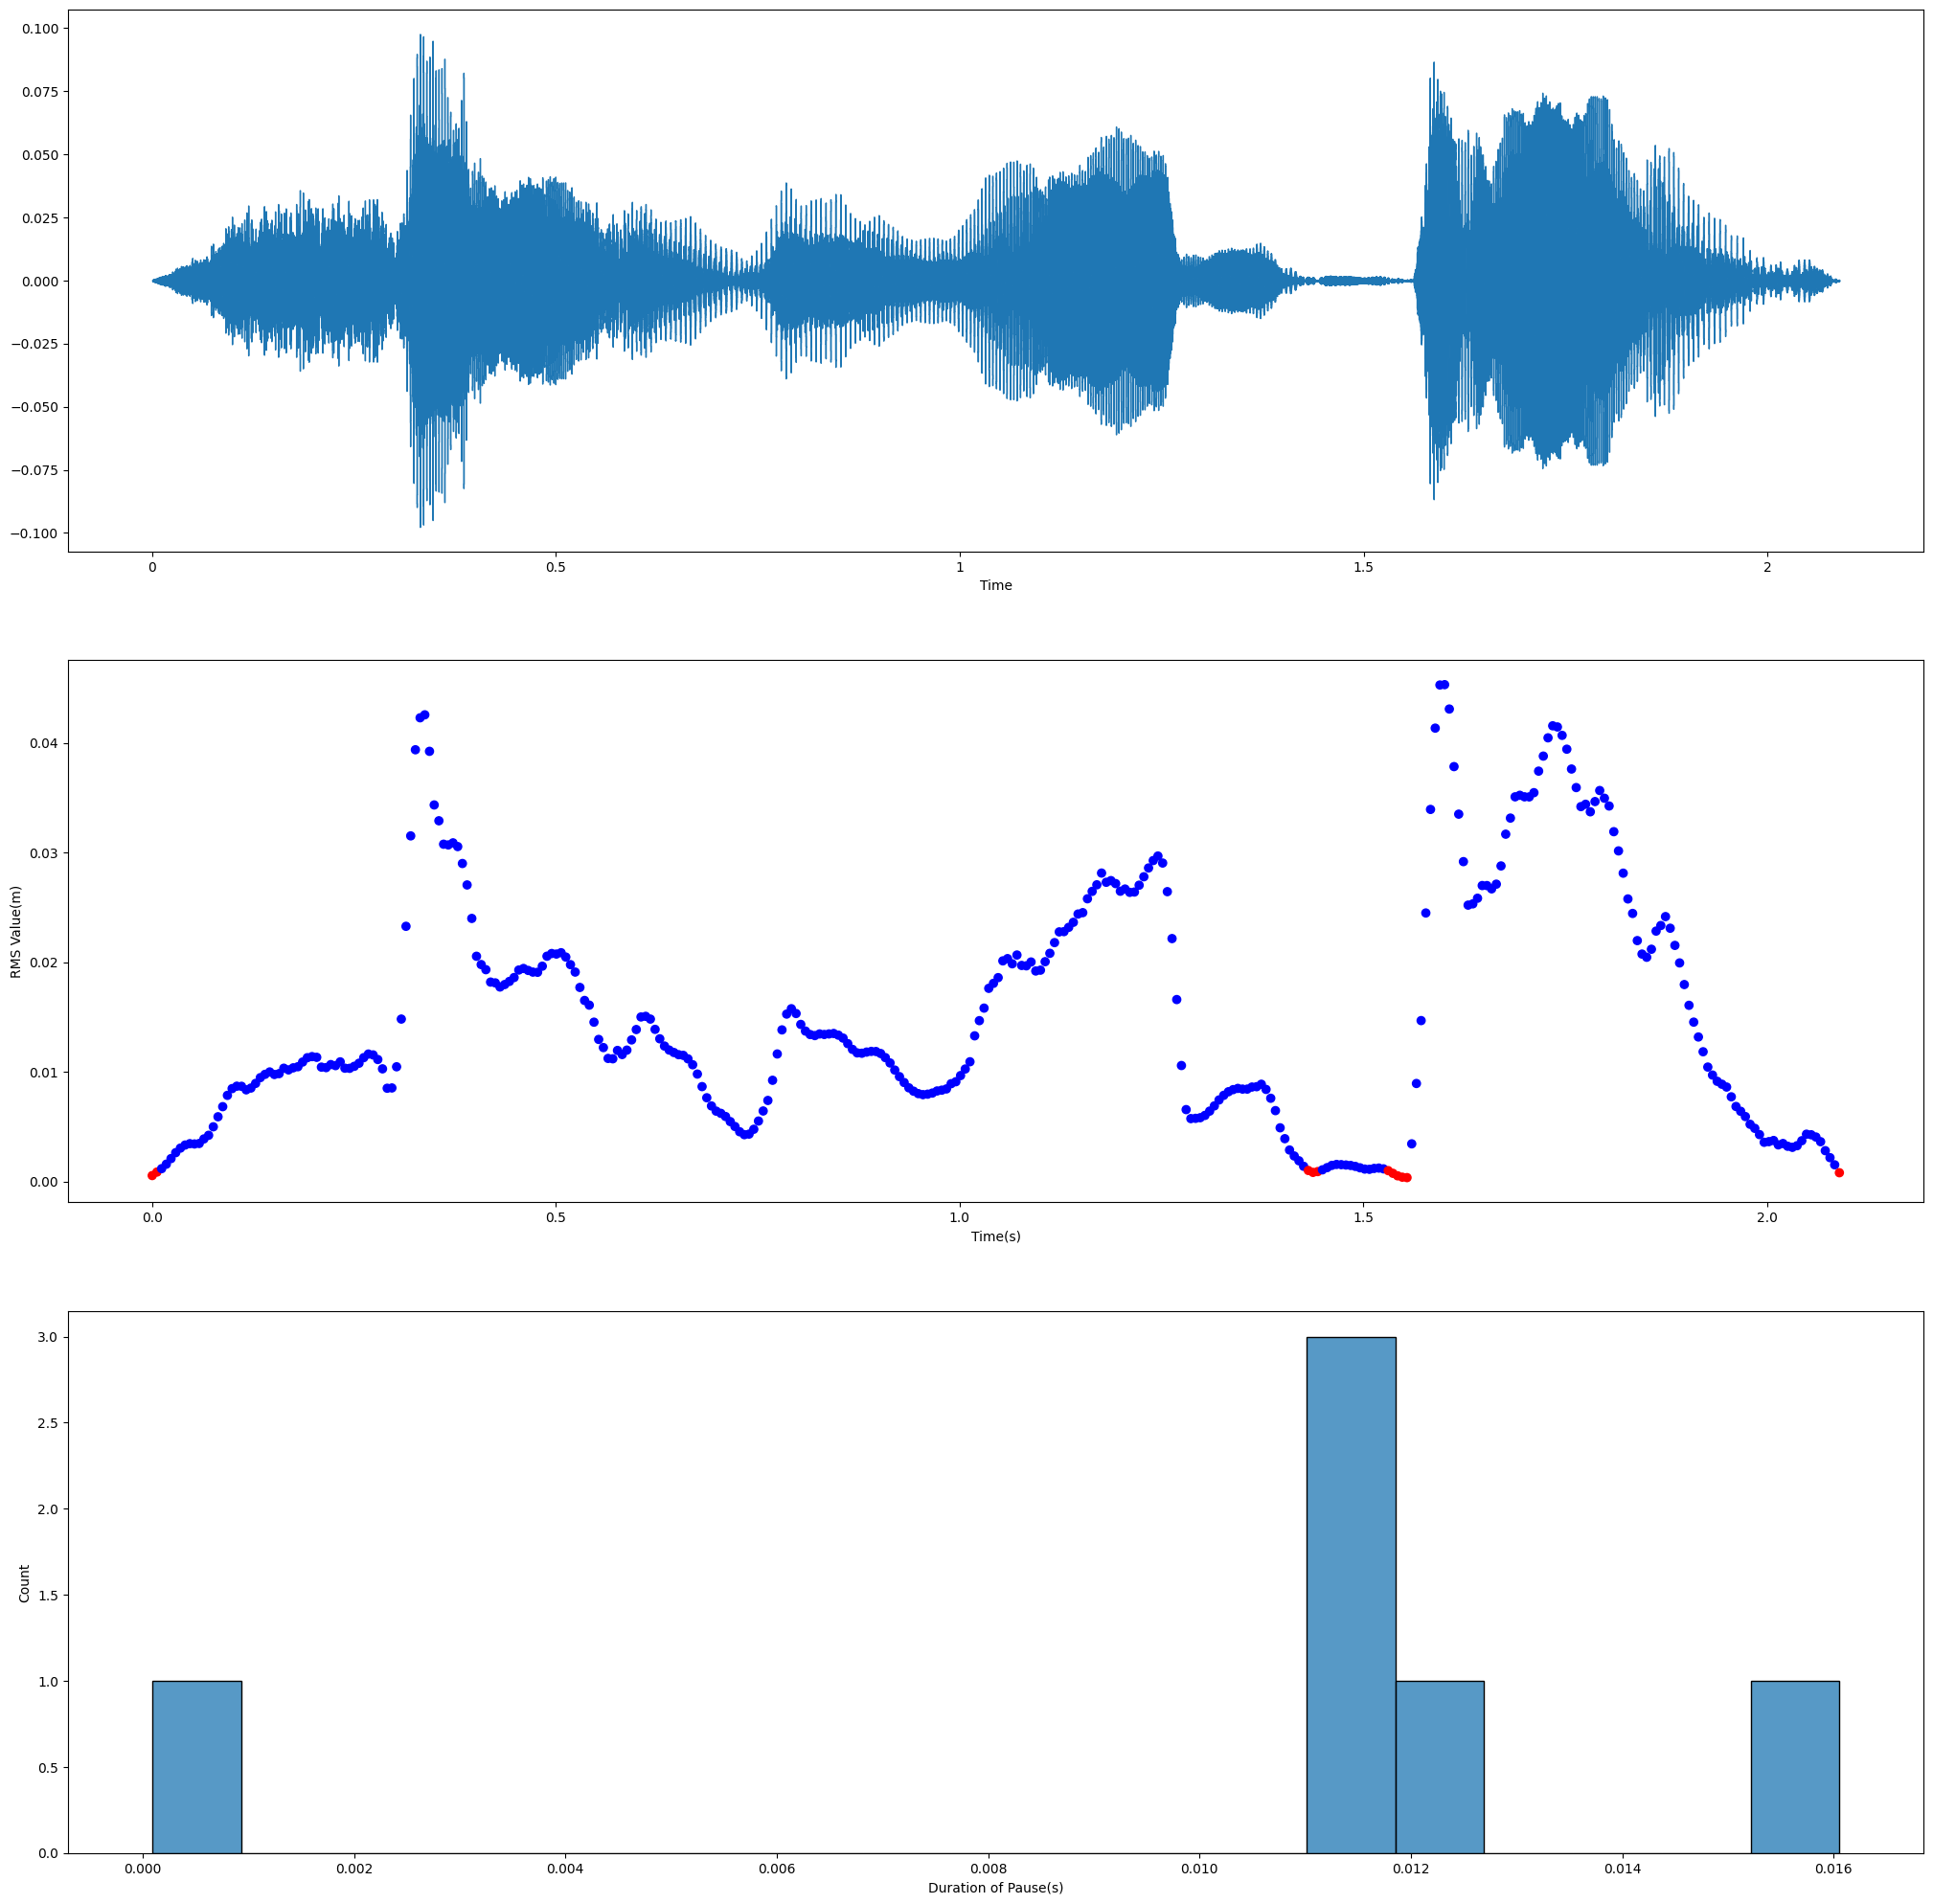

In [49]:
# Pauses
def plot_pauses(signal, sr):

  fig, axes = plt.subplots(nrows = 3, figsize = (25, 25))
  librosa.display.waveshow(y = signal, ax = axes[0])
  rms = librosa.feature.rms(y = signal, frame_length = 512, hop_length = 128)
  threshold = 0.001
  x = np.linspace(0, librosa.get_duration(y = signal, sr = sr), rms.shape[1])
  colors = []
  for i in range(rms.shape[1]):
    colors.append('green' if rms.T[i] > threshold else 'red')
  axes[1].scatter(x, rms.T, c = colors)
  
  pauses = []
  prev_color = 'red'
  present_pause = 0
  for color in colors:

    if (prev_color == color): present_pause += 1
    elif present_pause > 0: pauses.append(present_pause)
    prev_color = color

  pauses = np.array(pauses) / sr
  sb.histplot(pauses, ax = axes[2])
  axes[2].set_ylabel('Count')
  axes[2].set_xlabel('Duration of Pause(s)')
  axes[1].set_xlabel('Time(s)')
  axes[1].set_ylabel('RMS Value(m)')
  print(pauses)

plot_pauses(signal, sr)


In [13]:
# Slower speech rate
def detect_speech_rate(audio_file_path):
    # Initialize the recognizer
    recognizer = sr_.Recognizer()

    # Load the audio file
    audio_file = sr_.AudioFile(audio_file_path)
    signal, sr = librosa.load(audio_file_path)
    # Use the recognizer to transcribe the speech
    with audio_file as source:
        audio_data = recognizer.record(source)

    rms = librosa.feature.rms(y = signal, frame_length = 512, hop_length = 128)
    threshold = 0.002
    colors = []
    for i in range(rms.shape[1]):
      colors.append('blue' if rms.T[i] > threshold else 'red')

    pauses = []
    prev_color = 'red'
    present_pause = 0
    for color in colors:

      if (prev_color == color): present_pause += 1
      elif present_pause > 0: pauses.append(present_pause)
      prev_color = color

    pauses = np.array(pauses) / sr
    pauses_sum = np.sum(pauses)

    try:
        # Use Google Web Speech API for speech recognition
        transcript = recognizer.recognize_google(audio_data)
        
        # Count the number of words in the transcript
        word_count = len(transcript.split())

        # Get the duration of the audio in seconds
        audio_duration = librosa.get_duration(y = signal, sr = sr)

        # Calculate speech rate (words per minute)
        speech_rate = word_count / (audio_duration - pauses_sum)

        return speech_rate

    except:
        return None

In [ ]:
def global_speech_rate_stats(df):
    
    vals = {}
    counts = {}
    
    for emotion in emotions:
        vals[emotion] = 0
        counts[emotion] = 0
        
    for ind in tqdm(df.index):
        
        speech_rate = detect_speech_rate(df['addr'][ind])
        emotion = df['label'][ind]
        if(speech_rate is not None): vals[emotion] += speech_rate
        counts[emotion] += 1
        
    labels = []
    values = []
    colors = []
        
    for emotion in emotions:
        vals[emotion] /= counts[emotion]
        labels.append(emotion)
        values.append(vals[emotion])
        colors.append(labels_color[emotion])
    for i in range(len(values)):
        sb.swarmplot(y = values[i], c = colors[i], label = labels[i])
    plt.legend(loc = 'best')
    
global_speech_rate_stats(df)

 16%|█▌        | 446/2800 [04:08<31:18,  1.25it/s]

In [19]:
detect_speech_rate(df['addr'][403])

1.5899340231459784

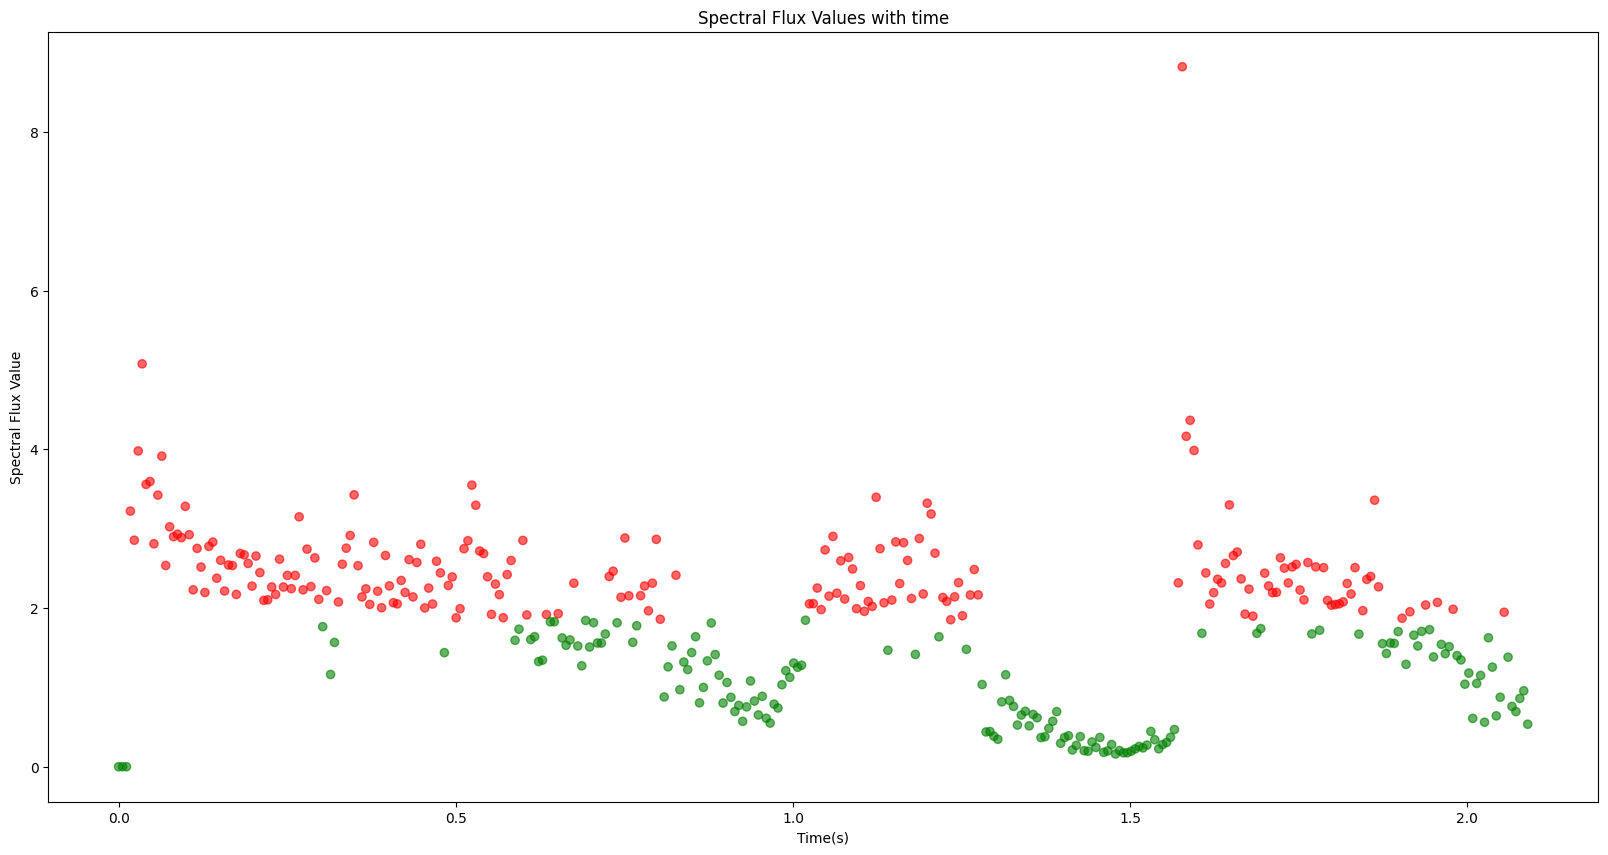

In [68]:
# Spectral slope
def plot_spec_flux(signal, sr):
    
    y = get_spec_flux(signal, sr)
    x = np.linspace(0, librosa.get_duration(y = signal, sr = sr), y.shape[0])
    flux_mean = np.mean(y, axis = 0)
    colors = []
    for i in range(y.shape[0]):
        colors.append('red' if y[i] > flux_mean else 'green')
    plt.figure(figsize = (20, 10))
    plt.scatter(x, y, c = colors, alpha = 0.6)
    plt.xlabel('Time(s)')
    plt.ylabel('Spectral Flux Value')
    plt.title('Spectral Flux Values with time')
    
plot_spec_flux(signal, sr)

In [58]:
# Kurtosis
def plot_kurtosis(signal, sr):
    coeffs = get_spectral_kurtosis(signal, sr, win_length = 1)[:257]
    x = np.linspace(0, 256/512 * sr, 257)
    plt.figure(figsize = (20, 10))
    plt.scatter(x, coeffs, alpha = 0.6)
    plt.xlabel('Frequency(Hz)')
    plt.ylabel('Kurtosis Value')
    plt.title('Kurtosis values of different frequency components')
    
def global_kurtosis(signal, sr):
    
    coeffs = {}
    counts = {}
    
    for emotion in emotions:
        coeffs[emotion] = np.zeros(257)
        counts[emotion] = 0
        
    for ind in tqdm(df.index):
        
        signal, sr = librosa.load(df['addr'][ind])
        coeff = get_spectral_kurtosis(signal, sr, win_length = 1)[:257]
        coeffs[emotion] += coeff
        counts[emotion] += 1
        
    for emotion in emotions:
        coeffs[emotion] /= counts[emotion]
        
    x = np.linspace(0, 256/512 * sr, 257)
    plt.figure(figsize = (20, 10))
    
    for emotion in emotions:
        plt.scatter(x, coeffs[emotion], alpha = 0.6, c = labels_color[emotion], label = emotion)
        
    plt.xlabel('Frequency(Hz)')
    plt.ylabel('Kurtosis Value')
    plt.title('Kurtosis values of different frequency components')
    plt.legend(loc = 'best')
    
global_kurtosis(signal, sr)

  1%|          | 17/2800 [00:07<19:33,  2.37it/s]


KeyboardInterrupt: 

In [62]:
# Skewness
def plot_skewness(signal, sr):
    coeffs = spectral_skewness(signal, sr, win_length = 1)[:257]
    x = np.linspace(0, 256/512 * sr, 257)
    plt.figure(figsize = (20, 10))
    plt.scatter(x, coeffs, alpha = 0.6)
    plt.xlabel('Frequency(Hz)')
    plt.ylabel('Skewness Value')
    plt.title('Skewness values of different frequency components')
    
def global_skewness(signal, sr):
    
    coeffs = {}
    counts = {}
    
    for emotion in emotions:
        coeffs[emotion] = np.zeros(257)
        counts[emotion] = 0
        
    for ind in tqdm(df.index):
        
        signal, sr = librosa.load(df['addr'][ind])
        coeff = get_spectral_kurtosis(signal, sr, win_length = 1)[:257]
        coeffs[emotion] += coeff
        counts[emotion] += 1
        
    for emotion in emotions:
        coeffs[emotion] /= counts[emotion]
        
    x = np.linspace(0, 256/512 * sr, 257)
    plt.figure(figsize = (20, 10))
    
    for emotion in emotions:
        plt.scatter(x, coeffs[emotion], alpha = 0.6, c = labels_color[emotion], label = emotion)
        
    plt.xlabel('Frequency(Hz)')
    plt.ylabel('Skewness Value')
    plt.title('Skewness values of different frequency components')
    plt.legend(loc = 'best')
    
global_skewness(signal, sr)

  0%|          | 8/2800 [00:03<20:39,  2.25it/s]


KeyboardInterrupt: 

In [12]:
formant_conf_str = '''
[componentInstances:cComponentManager]
instance[dataMemory].type=cDataMemory

;;; default source
[componentInstances:cComponentManager]
instance[dataMemory].type=cDataMemory

;;; source

\{\cm[source{?}:include external source]}

;;; main section

[componentInstances:cComponentManager]
instance[framer].type = cFramer
instance[win].type = cWindower
instance[fft].type = cTransformFFT
instance[resamp].type = cSpecResample
instance[lpc].type = cLpc
instance[formant].type = cFormantLpc

[framer:cFramer]
reader.dmLevel = wave
writer.dmLevel = frames
copyInputName = 1
frameMode = fixed
frameSize = 0.0232199546
frameStep = 0.00580498866
frameCenterSpecial = left
noPostEOIprocessing = 1

[win:cWindower]
reader.dmLevel=frames
writer.dmLevel=win
winFunc=gauss
gain=1.0

[fft:cTransformFFT]
reader.dmLevel=win
writer.dmLevel=fft

[resamp:cSpecResample]
reader.dmLevel=fft
writer.dmLevel=outpR
targetFs = 11000

[lpc:cLpc]
reader.dmLevel=outpR
writer.dmLevel=lpc
p=11
method=acf
lpGain=1
saveLPCoeff=1
residual=0
forwardFilter=0
lpSpectrum=0
lpSpecBins=128

[formant:cFormantLpc]
reader.dmLevel=lpc
writer.dmLevel=formant
saveIntensity=1
saveBandwidths=0
maxF=5500.0
minF=50.0
nFormants=3
useLpSpec=0
medianFilter=0
octaveCorrection=0

;;; sink

\{\cm[sink{?}:include external sink]}
'''
with open('formant.conf', 'w') as fp:
    fp.write(formant_conf_str)

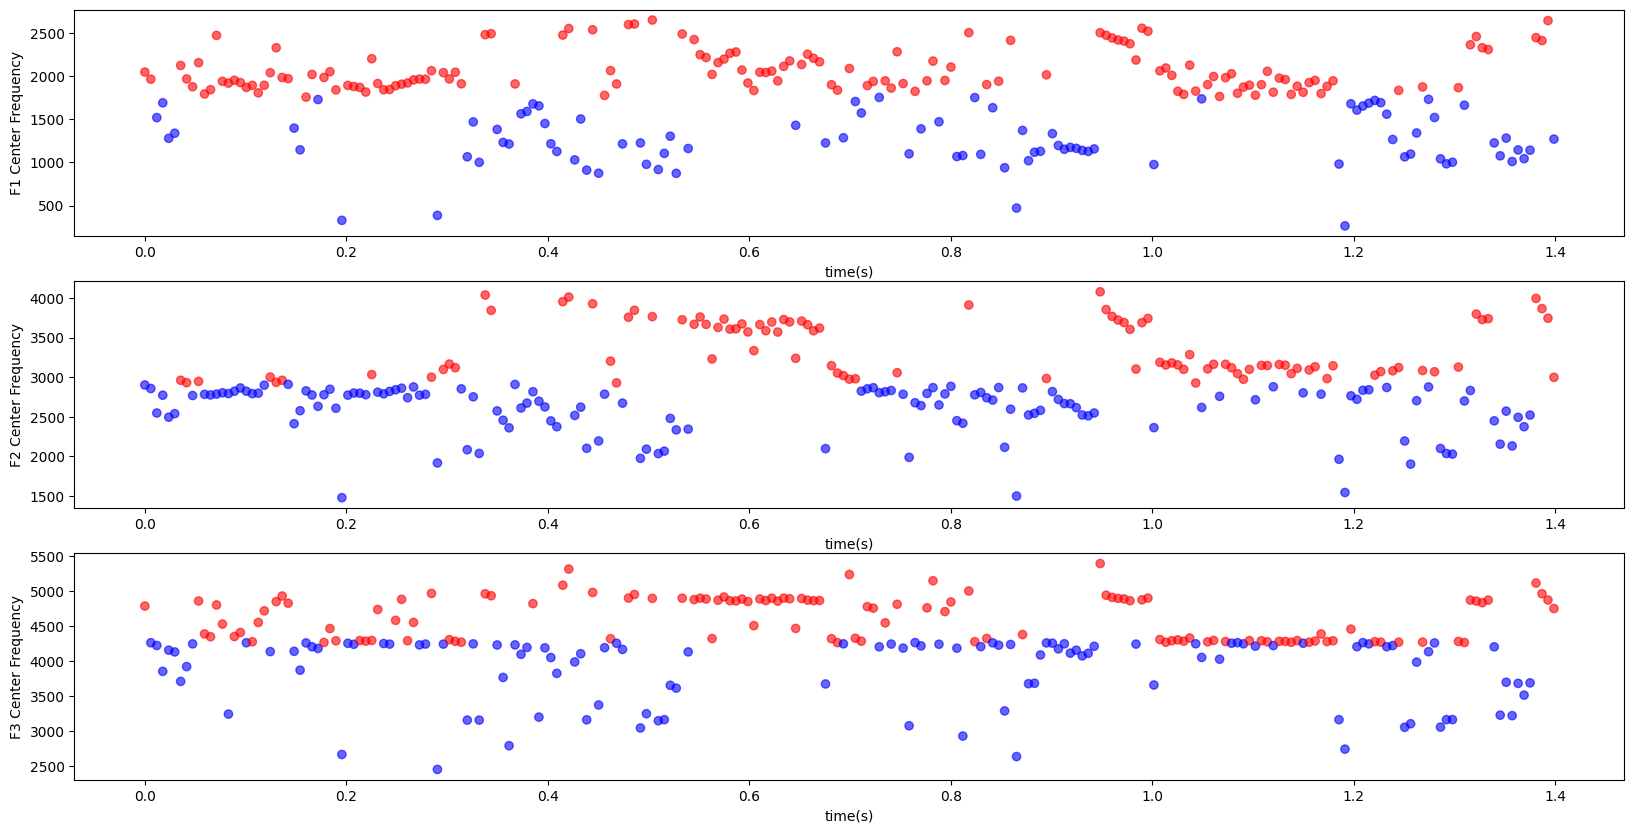

In [13]:
# Formant amplitude, bandwidth, frequency
smile = opensmile.Smile(
    feature_set = '/kaggle/working/formant.conf',
    feature_level= 'formant',
)

def get_formants(addr, smile):
    
    # Extact this for our test sentence, out comes a pandas dataframe
    result_df = smile.process_file(addr)
    formant_1 = result_df['formantFreqLpc[1]']
    formant_2 = result_df['formantFreqLpc[2]']
    formant_3 = result_df['formantFreqLpc[3]']
    return (formant_1, formant_2, formant_3)

def get_formants_mean(addr, smile):
    formant_1, formant_2, formant_3 = get_formants(addr, smile)
    return np.mean(np.array(formant_1)), np.mean(np.array(formant_2)), np.mean(np.array(formant_3))
    
def plot_formants(addr, smile):
    
    formant_1, formant_2, formant_3 = get_formants(addr, smile)
    fig, axes = plt.subplots(nrows = 3, ncols = 1, figsize = (20, 10))
    signal, sr = librosa.load(addr)
    x = np.linspace(0, librosa.get_duration(y = signal, sr = sr), len(formant_1))
    means = [np.mean(np.array(formant_1)), np.mean(np.array(formant_2)), np.mean(np.array(formant_3))]
    colors_1 = []
    colors_2 = []
    colors_3 = []
    
    for f in formant_1:
        if(f > means[0]): colors_1.append('red')
        else: colors_1.append('blue')
            
    for f in formant_2:
        if(f > means[1]): colors_2.append('red')
        else: colors_2.append('blue')
            
    for f in formant_3:
        if(f > means[2]): colors_3.append('red')
        else: colors_3.append('blue')
    
    
    axes[0].scatter(x, formant_1, c = colors_1, alpha = 0.6)
    axes[1].scatter(x, formant_2, c = colors_2, alpha = 0.6)
    axes[2].scatter(x, formant_3, c = colors_3, alpha = 0.6)
    
    axes[0].set_xlabel('time(s)')
    axes[1].set_xlabel('time(s)')
    axes[2].set_xlabel('time(s)')
    
    axes[0].set_ylabel('F1 Center Frequency')
    axes[1].set_ylabel('F2 Center Frequency')
    axes[2].set_ylabel('F3 Center Frequency')
    
    
plot_formants(df['addr'][0], smile)

100%|██████████| 2800/2800 [03:52<00:00, 12.04it/s]


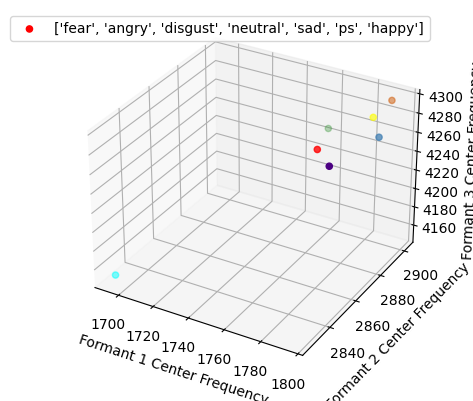

In [36]:
def get_global_formants(df, smile):
    
    vals_1= {}
    vals_2 = {}
    vals_3 = {}
    count = {}
    for emotion in emotions:
        vals_1[emotion] = 0
        vals_2[emotion] = 0
        vals_3[emotion] = 0
        count[emotion] = 0
    
    for ind in tqdm(df.index):
        formant_1, formant_2, formant_3 = get_formants_mean(df['addr'][ind], smile)
        emotion = df['label'][ind]
        
        vals_1[emotion] += formant_1
        vals_2[emotion] += formant_2
        vals_3[emotion] += formant_3
        count[emotion]+= 1
        
    x = []
    y = []
    z = []
    colors = []
    labels = []
        
    for emotion in emotions:
        vals_1[emotion] /= count[emotion]
        vals_2[emotion] /= count[emotion]
        vals_3[emotion] /= count[emotion]
        
        x.append(vals_1[emotion])
        y.append(vals_2[emotion])
        z.append(vals_3[emotion])
        colors.append(labels_color[emotion])
        labels.append(emotion)
    
    fig = plt.figure(figsize = (20, 20))
    ax = fig.add_subplot(111, projection='3d')
    
    
    for i in range(len(x)):
        ax.scatter(x[i], y[i], z[i], c = colors[i], label = labels[i])
        
    ax.set_xlabel('Formant 1 Center Frequency')
    ax.set_ylabel('Formant 2 Center Frequency')
    ax.set_zlabel('Formant 3 Center Frequency')
    plt.legend(loc = 'best')
    plt.show()
    
get_global_formants(df, smile)